# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.8460571322144843 -2.7299966635595387
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 gloss:0.1741 dloss:1.5524 dlossR:0.8816 dlossQ:0.6707
Episode:1 meanR:10.0000 gloss:0.1235 dloss:1.5145 dlossR:0.8354 dlossQ:0.6791
Episode:2 meanR:10.0000 gloss:0.0830 dloss:1.4828 dlossR:0.7980 dlossQ:0.6847
Episode:3 meanR:9.7500 gloss:0.0384 dloss:1.4333 dlossR:0.7426 dlossQ:0.6907
Episode:4 meanR:9.8000 gloss:0.0112 dloss:1.4060 dlossR:0.7136 dlossQ:0.6924
Episode:5 meanR:9.6667 gloss:-0.0167 dloss:1.3685 dlossR:0.6755 dlossQ:0.6929
Episode:6 meanR:9.5714 gloss:-0.0429 dloss:1.3352 dlossR:0.6436 dlossQ:0.6916
Episode:7 meanR:9.3750 gloss:-0.0701 dloss:1.3005 dlossR:0.6118 dlossQ:0.6887
Episode:8 meanR:9.5556 gloss:-0.0846 dloss:1.2514 dlossR:0.5699 dlossQ:0.6815
Episode:9 meanR:9.5000 gloss:-0.1164 dloss:1.2272 dlossR:0.5504 dlossQ:0.6768
Episode:10 meanR:9.4545 gloss:-0.1439 dloss:1.1887 dlossR:0.5206 dlossQ:0.6681
Episode:11 meanR:9.4167 gloss:-0.1722 dloss:1.1518 dlossR:0.4937 dlossQ:0.6581
Episode:12 meanR:9.3846 gloss:-0.2002 dloss:1.1282 dlossR:0.4779

Episode:114 meanR:18.5000 gloss:-2.2392 dloss:0.2747 dlossR:0.1118 dlossQ:0.1629
Episode:115 meanR:18.5600 gloss:-2.1951 dloss:0.3101 dlossR:0.1382 dlossQ:0.1719
Episode:116 meanR:18.6300 gloss:-2.1002 dloss:0.3350 dlossR:0.1459 dlossQ:0.1891
Episode:117 meanR:18.8500 gloss:-1.9836 dloss:0.4386 dlossR:0.2280 dlossQ:0.2106
Episode:118 meanR:19.0400 gloss:-2.0121 dloss:0.4261 dlossR:0.2221 dlossQ:0.2040
Episode:119 meanR:19.3300 gloss:-1.9838 dloss:0.4830 dlossR:0.2734 dlossQ:0.2096
Episode:120 meanR:19.8500 gloss:-1.9696 dloss:0.6158 dlossR:0.4042 dlossQ:0.2116
Episode:121 meanR:20.1600 gloss:-1.9721 dloss:0.5018 dlossR:0.2903 dlossQ:0.2114
Episode:122 meanR:20.5600 gloss:-1.9763 dloss:0.5466 dlossR:0.3362 dlossQ:0.2104
Episode:123 meanR:20.8800 gloss:-1.9733 dloss:0.5017 dlossR:0.2903 dlossQ:0.2114
Episode:124 meanR:21.1000 gloss:-2.0020 dloss:0.4452 dlossR:0.2394 dlossQ:0.2058
Episode:125 meanR:21.1100 gloss:-2.1468 dloss:0.2977 dlossR:0.1153 dlossQ:0.1824
Episode:126 meanR:21.2800 gl

Episode:220 meanR:40.4800 gloss:-1.9827 dloss:0.3491 dlossR:0.1292 dlossQ:0.2200
Episode:221 meanR:40.1700 gloss:-1.9831 dloss:0.3453 dlossR:0.1246 dlossQ:0.2207
Episode:222 meanR:39.8700 gloss:-1.7454 dloss:0.4530 dlossR:0.1801 dlossQ:0.2729
Episode:223 meanR:39.5700 gloss:-1.8136 dloss:0.3842 dlossR:0.1328 dlossQ:0.2514
Episode:224 meanR:39.9700 gloss:-1.5921 dloss:0.7343 dlossR:0.4276 dlossQ:0.3066
Episode:225 meanR:41.6600 gloss:-1.6303 dloss:1.2354 dlossR:0.9399 dlossQ:0.2955
Episode:226 meanR:42.8900 gloss:-1.6287 dloss:1.0845 dlossR:0.7888 dlossQ:0.2957
Episode:227 meanR:44.3100 gloss:-1.6029 dloss:1.1348 dlossR:0.8320 dlossQ:0.3028
Episode:228 meanR:45.5100 gloss:-1.5991 dloss:1.0843 dlossR:0.7808 dlossQ:0.3035
Episode:229 meanR:46.3800 gloss:-1.5445 dloss:0.9126 dlossR:0.5942 dlossQ:0.3184
Episode:230 meanR:47.1000 gloss:-1.5363 dloss:0.8478 dlossR:0.5272 dlossQ:0.3207
Episode:231 meanR:46.9200 gloss:-1.3987 dloss:0.5710 dlossR:0.2097 dlossQ:0.3613
Episode:232 meanR:46.9400 gl

Episode:322 meanR:32.6200 gloss:-2.0160 dloss:0.4037 dlossR:0.1990 dlossQ:0.2047
Episode:323 meanR:32.7700 gloss:-2.0073 dloss:0.4116 dlossR:0.2050 dlossQ:0.2066
Episode:324 meanR:32.6100 gloss:-1.9650 dloss:0.5896 dlossR:0.3750 dlossQ:0.2145
Episode:325 meanR:31.8500 gloss:-1.9854 dloss:0.8616 dlossR:0.6518 dlossQ:0.2098
Episode:326 meanR:30.7500 gloss:-2.0000 dloss:0.4812 dlossR:0.2740 dlossQ:0.2072
Episode:327 meanR:29.9100 gloss:-1.9310 dloss:0.7003 dlossR:0.4784 dlossQ:0.2219
Episode:328 meanR:28.8600 gloss:-1.9347 dloss:0.5217 dlossR:0.3002 dlossQ:0.2215
Episode:329 meanR:28.4100 gloss:-1.8813 dloss:0.6508 dlossR:0.4177 dlossQ:0.2331
Episode:330 meanR:28.1700 gloss:-1.8494 dloss:0.6870 dlossR:0.4466 dlossQ:0.2404
Episode:331 meanR:28.2700 gloss:-1.8773 dloss:0.4677 dlossR:0.2331 dlossQ:0.2346
Episode:332 meanR:28.4800 gloss:-1.8060 dloss:0.5989 dlossR:0.3480 dlossQ:0.2509
Episode:333 meanR:28.5600 gloss:-1.8200 dloss:0.5025 dlossR:0.2544 dlossQ:0.2480
Episode:334 meanR:28.7500 gl

Episode:424 meanR:49.4700 gloss:-1.3879 dloss:0.7323 dlossR:0.3673 dlossQ:0.3651
Episode:425 meanR:48.8300 gloss:-1.3771 dloss:0.6563 dlossR:0.2878 dlossQ:0.3684
Episode:426 meanR:48.9500 gloss:-1.3532 dloss:0.7042 dlossR:0.3283 dlossQ:0.3758
Episode:427 meanR:48.6300 gloss:-1.3402 dloss:0.6818 dlossR:0.3018 dlossQ:0.3799
Episode:428 meanR:48.7300 gloss:-1.3111 dloss:0.7300 dlossR:0.3413 dlossQ:0.3887
Episode:429 meanR:48.3500 gloss:-1.3512 dloss:0.6164 dlossR:0.2393 dlossQ:0.3771
Episode:430 meanR:47.8800 gloss:-1.3585 dloss:0.6020 dlossR:0.2269 dlossQ:0.3751
Episode:431 meanR:47.8100 gloss:-1.3747 dloss:0.5959 dlossR:0.2254 dlossQ:0.3705
Episode:432 meanR:47.5700 gloss:-1.3603 dloss:0.6213 dlossR:0.2464 dlossQ:0.3749
Episode:433 meanR:47.4600 gloss:-1.3742 dloss:0.5963 dlossR:0.2256 dlossQ:0.3707
Episode:434 meanR:47.3300 gloss:-1.3754 dloss:0.6115 dlossR:0.2411 dlossQ:0.3704
Episode:435 meanR:47.2300 gloss:-1.4895 dloss:0.5158 dlossR:0.1780 dlossQ:0.3377
Episode:436 meanR:46.7300 gl

Episode:531 meanR:68.5900 gloss:-0.8899 dloss:0.8361 dlossR:0.3116 dlossQ:0.5245
Episode:532 meanR:68.5600 gloss:-0.8638 dloss:0.8519 dlossR:0.3195 dlossQ:0.5324
Episode:533 meanR:68.6300 gloss:-0.8408 dloss:0.8758 dlossR:0.3365 dlossQ:0.5394
Episode:534 meanR:68.7000 gloss:-0.8511 dloss:0.8797 dlossR:0.3437 dlossQ:0.5360
Episode:535 meanR:69.0500 gloss:-0.8664 dloss:0.9087 dlossR:0.3776 dlossQ:0.5311
Episode:536 meanR:69.3500 gloss:-0.8642 dloss:0.9093 dlossR:0.3777 dlossQ:0.5316
Episode:537 meanR:69.9000 gloss:-0.8793 dloss:0.9578 dlossR:0.4310 dlossQ:0.5268
Episode:538 meanR:70.2800 gloss:-0.8979 dloss:0.9088 dlossR:0.3877 dlossQ:0.5211
Episode:539 meanR:70.8100 gloss:-0.9280 dloss:0.9216 dlossR:0.4100 dlossQ:0.5116
Episode:540 meanR:71.2500 gloss:-0.9468 dloss:0.8950 dlossR:0.3891 dlossQ:0.5058
Episode:541 meanR:71.5500 gloss:-0.9627 dloss:0.8465 dlossR:0.3457 dlossQ:0.5008
Episode:542 meanR:71.8700 gloss:-0.9912 dloss:0.8250 dlossR:0.3333 dlossQ:0.4917
Episode:543 meanR:72.1600 gl

Episode:633 meanR:86.5500 gloss:-0.9516 dloss:0.7985 dlossR:0.2919 dlossQ:0.5065
Episode:634 meanR:86.4400 gloss:-0.9390 dloss:0.8103 dlossR:0.2998 dlossQ:0.5105
Episode:635 meanR:86.2000 gloss:-0.9141 dloss:0.8287 dlossR:0.3105 dlossQ:0.5182
Episode:636 meanR:86.0300 gloss:-0.8988 dloss:0.8538 dlossR:0.3311 dlossQ:0.5227
Episode:637 meanR:85.7000 gloss:-0.8729 dloss:0.8800 dlossR:0.3503 dlossQ:0.5297
Episode:638 meanR:85.6900 gloss:-0.8834 dloss:0.9164 dlossR:0.3898 dlossQ:0.5266
Episode:639 meanR:86.0800 gloss:-0.9668 dloss:1.0199 dlossR:0.5198 dlossQ:0.5000
Episode:640 meanR:86.2800 gloss:-0.9099 dloss:0.9678 dlossR:0.4497 dlossQ:0.5182
Episode:641 meanR:87.4300 gloss:-0.8735 dloss:1.1823 dlossR:0.6521 dlossQ:0.5302
Episode:642 meanR:90.3100 gloss:-0.8188 dloss:1.5924 dlossR:1.0461 dlossQ:0.5463
Episode:643 meanR:94.8800 gloss:-0.8037 dloss:1.9838 dlossR:1.4330 dlossQ:0.5508
Episode:644 meanR:99.4700 gloss:-0.8042 dloss:1.9844 dlossR:1.4335 dlossQ:0.5509
Episode:645 meanR:104.1200 g

Episode:737 meanR:117.4400 gloss:-1.1667 dloss:0.7596 dlossR:0.3165 dlossQ:0.4431
Episode:738 meanR:117.0200 gloss:-1.4685 dloss:0.5399 dlossR:0.1893 dlossQ:0.3506
Episode:739 meanR:116.1100 gloss:-1.3684 dloss:0.5812 dlossR:0.2021 dlossQ:0.3791
Episode:740 meanR:115.5800 gloss:-1.1154 dloss:0.7413 dlossR:0.2817 dlossQ:0.4596
Episode:741 meanR:114.4400 gloss:-1.1478 dloss:0.8045 dlossR:0.3492 dlossQ:0.4553
Episode:742 meanR:111.6200 gloss:-0.9909 dloss:0.8565 dlossR:0.3593 dlossQ:0.4972
Episode:743 meanR:107.2900 gloss:-1.0760 dloss:0.8934 dlossR:0.4194 dlossQ:0.4741
Episode:744 meanR:102.8800 gloss:-1.1139 dloss:0.8543 dlossR:0.3925 dlossQ:0.4618
Episode:745 meanR:98.2300 gloss:-0.9833 dloss:0.8244 dlossR:0.3261 dlossQ:0.4983
Episode:746 meanR:93.6200 gloss:-1.0199 dloss:0.8179 dlossR:0.3303 dlossQ:0.4876
Episode:747 meanR:89.0800 gloss:-0.9793 dloss:0.8544 dlossR:0.3551 dlossQ:0.4993
Episode:748 meanR:86.0400 gloss:-0.9809 dloss:0.8745 dlossR:0.3769 dlossQ:0.4977
Episode:749 meanR:84

Episode:841 meanR:99.7100 gloss:-0.8378 dloss:1.1246 dlossR:0.5808 dlossQ:0.5438
Episode:842 meanR:101.2300 gloss:-0.8113 dloss:1.2914 dlossR:0.7396 dlossQ:0.5519
Episode:843 meanR:102.1200 gloss:-0.8423 dloss:1.1856 dlossR:0.6431 dlossQ:0.5426
Episode:844 meanR:105.6500 gloss:-0.7262 dloss:1.7439 dlossR:1.1693 dlossQ:0.5747
Episode:845 meanR:107.8100 gloss:-0.8745 dloss:1.4206 dlossR:0.8873 dlossQ:0.5333
Episode:846 meanR:112.4200 gloss:-0.8785 dloss:2.0535 dlossR:1.5218 dlossQ:0.5318
Episode:847 meanR:114.2000 gloss:-0.8188 dloss:1.3547 dlossR:0.8059 dlossQ:0.5488
Episode:848 meanR:114.6200 gloss:-0.8365 dloss:1.0518 dlossR:0.5078 dlossQ:0.5439
Episode:849 meanR:113.9200 gloss:-0.9889 dloss:0.8165 dlossR:0.3197 dlossQ:0.4968
Episode:850 meanR:109.0100 gloss:-1.3972 dloss:0.5732 dlossR:0.2002 dlossQ:0.3730
Episode:851 meanR:106.4900 gloss:-1.0640 dloss:0.7257 dlossR:0.2540 dlossQ:0.4717
Episode:852 meanR:105.9800 gloss:-0.9481 dloss:0.8165 dlossR:0.3086 dlossQ:0.5080
Episode:853 meanR

Episode:943 meanR:80.8100 gloss:-1.2530 dloss:0.8968 dlossR:0.4852 dlossQ:0.4116
Episode:944 meanR:79.0800 gloss:-1.1676 dloss:1.4218 dlossR:0.9808 dlossQ:0.4410
Episode:945 meanR:77.3400 gloss:-1.2279 dloss:0.8750 dlossR:0.4454 dlossQ:0.4296
Episode:946 meanR:73.0100 gloss:-1.2431 dloss:0.8299 dlossR:0.4070 dlossQ:0.4230
Episode:947 meanR:71.2100 gloss:-1.3148 dloss:0.7338 dlossR:0.3264 dlossQ:0.4074
Episode:948 meanR:71.3800 gloss:-1.1912 dloss:0.9949 dlossR:0.5608 dlossQ:0.4341
Episode:949 meanR:74.8800 gloss:-1.0475 dloss:1.8140 dlossR:1.3386 dlossQ:0.4753
Episode:950 meanR:79.7900 gloss:-1.0675 dloss:2.2062 dlossR:1.7360 dlossQ:0.4702
Episode:951 meanR:81.1700 gloss:-1.2177 dloss:1.1193 dlossR:0.6951 dlossQ:0.4242
Episode:952 meanR:81.4100 gloss:-1.3487 dloss:0.7237 dlossR:0.3332 dlossQ:0.3905
Episode:953 meanR:81.6000 gloss:-1.4247 dloss:0.6265 dlossR:0.2554 dlossQ:0.3711
Episode:954 meanR:83.1300 gloss:-1.0841 dloss:1.2098 dlossR:0.7448 dlossQ:0.4650
Episode:955 meanR:85.4900 gl

Episode:1044 meanR:274.5600 gloss:0.9138 dloss:0.7521 dlossR:0.2369 dlossQ:0.5152
Episode:1045 meanR:275.4300 gloss:0.7602 dloss:1.5894 dlossR:1.0272 dlossQ:0.5622
Episode:1046 meanR:279.1700 gloss:0.8321 dloss:0.9479 dlossR:0.4095 dlossQ:0.5384
Episode:1047 meanR:283.0900 gloss:0.9471 dloss:0.9086 dlossR:0.4043 dlossQ:0.5044
Episode:1048 meanR:284.8200 gloss:0.7647 dloss:1.3232 dlossR:0.7659 dlossQ:0.5573
Episode:1049 meanR:286.0600 gloss:0.7872 dloss:0.8326 dlossR:0.2783 dlossQ:0.5544
Episode:1050 meanR:286.0600 gloss:0.7805 dloss:0.8370 dlossR:0.2806 dlossQ:0.5564
Episode:1051 meanR:285.3200 gloss:0.7982 dloss:1.8011 dlossR:1.2501 dlossQ:0.5510
Episode:1052 meanR:287.2300 gloss:0.8684 dloss:1.4353 dlossR:0.9061 dlossQ:0.5292
Episode:1053 meanR:287.8000 gloss:0.6946 dloss:1.7279 dlossR:1.1468 dlossQ:0.5811
Episode:1054 meanR:286.6900 gloss:0.6451 dloss:1.7396 dlossR:1.1449 dlossQ:0.5947
Episode:1055 meanR:284.6200 gloss:0.6609 dloss:1.7481 dlossR:1.1575 dlossQ:0.5906
Episode:1056 mea

Episode:1144 meanR:146.3500 gloss:-0.6879 dloss:1.5338 dlossR:0.9568 dlossQ:0.5769
Episode:1145 meanR:149.7100 gloss:-0.7357 dloss:1.9318 dlossR:1.3639 dlossQ:0.5679
Episode:1146 meanR:150.3000 gloss:-0.6930 dloss:1.8976 dlossR:1.3171 dlossQ:0.5805
Episode:1147 meanR:150.9400 gloss:-0.6608 dloss:1.8724 dlossR:1.2821 dlossQ:0.5903
Episode:1148 meanR:153.0800 gloss:-0.6303 dloss:1.8483 dlossR:1.2490 dlossQ:0.5994
Episode:1149 meanR:148.2000 gloss:-1.2342 dloss:0.6435 dlossR:0.2250 dlossQ:0.4185
Episode:1150 meanR:143.3000 gloss:-0.9720 dloss:0.7627 dlossR:0.2666 dlossQ:0.4961
Episode:1151 meanR:142.6300 gloss:-0.8449 dloss:0.8377 dlossR:0.3022 dlossQ:0.5355
Episode:1152 meanR:140.3700 gloss:-0.9803 dloss:0.7872 dlossR:0.2923 dlossQ:0.4949
Episode:1153 meanR:139.6500 gloss:-0.9673 dloss:0.7948 dlossR:0.2970 dlossQ:0.4978
Episode:1154 meanR:139.1200 gloss:-0.9993 dloss:0.7711 dlossR:0.2820 dlossQ:0.4891
Episode:1155 meanR:138.6200 gloss:-0.9643 dloss:0.7929 dlossR:0.2930 dlossQ:0.4998
Epis

Episode:1246 meanR:86.4800 gloss:-1.7214 dloss:0.4561 dlossR:0.1650 dlossQ:0.2911
Episode:1247 meanR:86.4800 gloss:-0.8140 dloss:1.9969 dlossR:1.4493 dlossQ:0.5477
Episode:1248 meanR:81.5700 gloss:-1.9551 dloss:0.4056 dlossR:0.1519 dlossQ:0.2537
Episode:1249 meanR:86.4500 gloss:-0.8835 dloss:2.0484 dlossR:1.5218 dlossQ:0.5266
Episode:1250 meanR:86.9100 gloss:-0.9445 dloss:0.8914 dlossR:0.3843 dlossQ:0.5071
Episode:1251 meanR:87.1300 gloss:-0.9684 dloss:0.8161 dlossR:0.3153 dlossQ:0.5008
Episode:1252 meanR:87.1100 gloss:-1.3921 dloss:0.5641 dlossR:0.1918 dlossQ:0.3723
Episode:1253 meanR:87.1100 gloss:-1.4590 dloss:0.5437 dlossR:0.1899 dlossQ:0.3538
Episode:1254 meanR:87.1300 gloss:-1.3272 dloss:0.5975 dlossR:0.2059 dlossQ:0.3916
Episode:1255 meanR:87.3400 gloss:-0.9448 dloss:0.8408 dlossR:0.3311 dlossQ:0.5097
Episode:1256 meanR:82.8300 gloss:-0.8716 dloss:0.9089 dlossR:0.3793 dlossQ:0.5296
Episode:1257 meanR:78.9300 gloss:-0.8195 dloss:1.0761 dlossR:0.5312 dlossQ:0.5450
Episode:1258 mea

Episode:1346 meanR:181.0000 gloss:-0.7572 dloss:1.1037 dlossR:0.5489 dlossQ:0.5547
Episode:1347 meanR:176.4300 gloss:-0.5627 dloss:1.0635 dlossR:0.4535 dlossQ:0.6100
Episode:1348 meanR:176.7000 gloss:-0.3910 dloss:1.1520 dlossR:0.4992 dlossQ:0.6528
Episode:1349 meanR:171.9500 gloss:-0.4212 dloss:1.1234 dlossR:0.4736 dlossQ:0.6498
Episode:1350 meanR:171.6400 gloss:-0.4097 dloss:1.1323 dlossR:0.4793 dlossQ:0.6529
Episode:1351 meanR:171.5300 gloss:-0.4813 dloss:1.0839 dlossR:0.4463 dlossQ:0.6375
Episode:1352 meanR:171.5900 gloss:-0.5411 dloss:1.0434 dlossR:0.4192 dlossQ:0.6243
Episode:1353 meanR:171.6800 gloss:-0.5319 dloss:1.0546 dlossR:0.4248 dlossQ:0.6298
Episode:1354 meanR:171.7000 gloss:-0.6381 dloss:0.9874 dlossR:0.3848 dlossQ:0.6026
Episode:1355 meanR:171.5300 gloss:-0.6363 dloss:0.9916 dlossR:0.3890 dlossQ:0.6026
Episode:1356 meanR:171.2500 gloss:-0.6696 dloss:0.9741 dlossR:0.3789 dlossQ:0.5952
Episode:1357 meanR:170.3200 gloss:-0.7590 dloss:0.9164 dlossR:0.3462 dlossQ:0.5702
Epis

Episode:1447 meanR:58.8000 gloss:-0.6391 dloss:1.3149 dlossR:0.7288 dlossQ:0.5861
Episode:1448 meanR:62.2800 gloss:-1.1670 dloss:1.9688 dlossR:1.5196 dlossQ:0.4492
Episode:1449 meanR:66.2700 gloss:-0.6809 dloss:1.7455 dlossR:1.1585 dlossQ:0.5870
Episode:1450 meanR:69.6600 gloss:-0.6079 dloss:1.6018 dlossR:0.9954 dlossQ:0.6064
Episode:1451 meanR:74.4500 gloss:-0.7512 dloss:1.9483 dlossR:1.3783 dlossQ:0.5700
Episode:1452 meanR:77.4600 gloss:-0.6599 dloss:1.5310 dlossR:0.9401 dlossQ:0.5909
Episode:1453 meanR:79.4200 gloss:-0.7222 dloss:1.3362 dlossR:0.7629 dlossQ:0.5734
Episode:1454 meanR:80.8800 gloss:-0.7733 dloss:1.2076 dlossR:0.6486 dlossQ:0.5591
Episode:1455 meanR:82.0300 gloss:-0.8327 dloss:1.1307 dlossR:0.5891 dlossQ:0.5416
Episode:1456 meanR:82.8700 gloss:-0.8684 dloss:1.0491 dlossR:0.5190 dlossQ:0.5301
Episode:1457 meanR:83.6800 gloss:-0.9073 dloss:1.0184 dlossR:0.4988 dlossQ:0.5195
Episode:1458 meanR:84.2600 gloss:-0.9631 dloss:0.9445 dlossR:0.4427 dlossQ:0.5018
Episode:1459 mea

Episode:1549 meanR:115.3200 gloss:-0.7993 dloss:1.5963 dlossR:1.0304 dlossQ:0.5659
Episode:1550 meanR:113.6300 gloss:-0.8596 dloss:1.3004 dlossR:0.7585 dlossQ:0.5419
Episode:1551 meanR:109.0400 gloss:-1.2315 dloss:0.7743 dlossR:0.3402 dlossQ:0.4341
Episode:1552 meanR:105.9900 gloss:-1.9340 dloss:0.4237 dlossR:0.1724 dlossQ:0.2513
Episode:1553 meanR:104.4900 gloss:-0.9822 dloss:0.9398 dlossR:0.4354 dlossQ:0.5044
Episode:1554 meanR:105.6500 gloss:-0.6682 dloss:1.4702 dlossR:0.8755 dlossQ:0.5947
Episode:1555 meanR:109.3100 gloss:-0.6801 dloss:1.9023 dlossR:1.3058 dlossQ:0.5965
Episode:1556 meanR:113.2600 gloss:-0.6069 dloss:1.8441 dlossR:1.2306 dlossQ:0.6135
Episode:1557 meanR:112.7100 gloss:-1.2732 dloss:0.7561 dlossR:0.3372 dlossQ:0.4189
Episode:1558 meanR:116.6800 gloss:-0.4740 dloss:1.7122 dlossR:1.0765 dlossQ:0.6357
Episode:1559 meanR:120.9100 gloss:-0.3921 dloss:1.6807 dlossR:1.0268 dlossQ:0.6539
Episode:1560 meanR:123.4100 gloss:-0.3890 dloss:1.4678 dlossR:0.8122 dlossQ:0.6556
Epis

Episode:1651 meanR:220.9900 gloss:-1.0914 dloss:0.8274 dlossR:0.3629 dlossQ:0.4645
Episode:1652 meanR:223.1500 gloss:-0.7167 dloss:1.3717 dlossR:0.8096 dlossQ:0.5621
Episode:1653 meanR:224.9100 gloss:-0.5927 dloss:1.3879 dlossR:0.7815 dlossQ:0.6064
Episode:1654 meanR:227.1300 gloss:-0.4141 dloss:1.6870 dlossR:1.0369 dlossQ:0.6501
Episode:1655 meanR:227.1300 gloss:-0.3750 dloss:1.6596 dlossR:1.0014 dlossQ:0.6582
Episode:1656 meanR:223.2200 gloss:-0.2185 dloss:1.3061 dlossR:0.6352 dlossQ:0.6709
Episode:1657 meanR:222.8800 gloss:-1.4299 dloss:0.6433 dlossR:0.2570 dlossQ:0.3864
Episode:1658 meanR:220.0600 gloss:-0.5441 dloss:1.3095 dlossR:0.6930 dlossQ:0.6166
Episode:1659 meanR:215.6800 gloss:-1.3092 dloss:0.8148 dlossR:0.4053 dlossQ:0.4095
Episode:1660 meanR:212.7100 gloss:-1.5449 dloss:0.5721 dlossR:0.2240 dlossQ:0.3481
Episode:1661 meanR:208.4400 gloss:-1.7837 dloss:0.4624 dlossR:0.1754 dlossQ:0.2871
Episode:1662 meanR:205.1300 gloss:-1.4552 dloss:0.5915 dlossR:0.2330 dlossQ:0.3585
Epis

Episode:1751 meanR:135.8400 gloss:-1.5659 dloss:0.5496 dlossR:0.2104 dlossQ:0.3392
Episode:1752 meanR:133.6700 gloss:-1.6800 dloss:0.5004 dlossR:0.1889 dlossQ:0.3115
Episode:1753 meanR:131.3900 gloss:-1.3879 dloss:0.6096 dlossR:0.2214 dlossQ:0.3883
Episode:1754 meanR:126.8000 gloss:-0.9305 dloss:0.8966 dlossR:0.3669 dlossQ:0.5297
Episode:1755 meanR:122.2500 gloss:-1.0556 dloss:0.8472 dlossR:0.3641 dlossQ:0.4832
Episode:1756 meanR:122.8600 gloss:-0.4636 dloss:1.2960 dlossR:0.6567 dlossQ:0.6393
Episode:1757 meanR:127.7700 gloss:-0.4360 dloss:1.7110 dlossR:1.0644 dlossQ:0.6465
Episode:1758 meanR:127.5400 gloss:-0.5918 dloss:1.2696 dlossR:0.6655 dlossQ:0.6041
Episode:1759 meanR:128.1300 gloss:-0.8785 dloss:1.1039 dlossR:0.5724 dlossQ:0.5315
Episode:1760 meanR:129.2500 gloss:-0.8788 dloss:1.1270 dlossR:0.6095 dlossQ:0.5174
Episode:1761 meanR:129.4600 gloss:-1.3259 dloss:0.6820 dlossR:0.2764 dlossQ:0.4055
Episode:1762 meanR:129.5700 gloss:-1.3623 dloss:0.6720 dlossR:0.2732 dlossQ:0.3988
Epis

Episode:1851 meanR:281.4200 gloss:0.2298 dloss:1.4265 dlossR:0.7607 dlossQ:0.6658
Episode:1852 meanR:283.2100 gloss:0.2520 dloss:1.4308 dlossR:0.7658 dlossQ:0.6651
Episode:1853 meanR:285.1100 gloss:0.1722 dloss:1.4092 dlossR:0.7374 dlossQ:0.6719
Episode:1854 meanR:286.6000 gloss:0.1728 dloss:1.4175 dlossR:0.7474 dlossQ:0.6701
Episode:1855 meanR:287.9000 gloss:0.1754 dloss:1.4259 dlossR:0.7562 dlossQ:0.6697
Episode:1856 meanR:287.8400 gloss:0.1078 dloss:1.4145 dlossR:0.7415 dlossQ:0.6730
Episode:1857 meanR:285.4200 gloss:0.0857 dloss:1.3854 dlossR:0.7161 dlossQ:0.6694
Episode:1858 meanR:285.2300 gloss:-0.0089 dloss:1.3853 dlossR:0.7096 dlossQ:0.6757
Episode:1859 meanR:285.5000 gloss:-0.1577 dloss:1.3421 dlossR:0.6727 dlossQ:0.6694
Episode:1860 meanR:285.8800 gloss:-0.1783 dloss:1.3433 dlossR:0.6733 dlossQ:0.6700
Episode:1861 meanR:287.3400 gloss:-0.1781 dloss:1.3506 dlossR:0.6843 dlossQ:0.6663
Episode:1862 meanR:288.4600 gloss:-0.3722 dloss:1.2738 dlossR:0.6294 dlossQ:0.6443
Episode:186

Episode:1950 meanR:108.8700 gloss:-0.4979 dloss:1.7603 dlossR:1.1192 dlossQ:0.6410
Episode:1951 meanR:108.6200 gloss:-0.6507 dloss:1.2778 dlossR:0.6813 dlossQ:0.5966
Episode:1952 meanR:108.7400 gloss:-0.5760 dloss:1.3404 dlossR:0.7207 dlossQ:0.6197
Episode:1953 meanR:108.1400 gloss:-0.5908 dloss:1.2567 dlossR:0.6404 dlossQ:0.6164
Episode:1954 meanR:108.5100 gloss:-0.5267 dloss:1.3745 dlossR:0.7470 dlossQ:0.6275
Episode:1955 meanR:108.4000 gloss:-0.8019 dloss:1.2664 dlossR:0.7039 dlossQ:0.5624
Episode:1956 meanR:108.0200 gloss:-0.8487 dloss:1.1698 dlossR:0.6214 dlossQ:0.5484
Episode:1957 meanR:106.4300 gloss:-0.7001 dloss:1.1361 dlossR:0.5497 dlossQ:0.5864
Episode:1958 meanR:106.9300 gloss:-0.4961 dloss:1.3423 dlossR:0.7105 dlossQ:0.6318
Episode:1959 meanR:109.4200 gloss:-0.5421 dloss:1.6383 dlossR:1.0136 dlossQ:0.6246
Episode:1960 meanR:109.8100 gloss:-0.5113 dloss:1.3391 dlossR:0.7168 dlossQ:0.6223
Episode:1961 meanR:109.7200 gloss:-0.5237 dloss:1.2855 dlossR:0.6591 dlossQ:0.6264
Epis

Episode:2052 meanR:142.3700 gloss:-1.0084 dloss:0.7948 dlossR:0.3036 dlossQ:0.4912
Episode:2053 meanR:141.0200 gloss:-1.5835 dloss:0.5481 dlossR:0.2122 dlossQ:0.3360
Episode:2054 meanR:138.8600 gloss:-1.5703 dloss:0.5548 dlossR:0.2150 dlossQ:0.3398
Episode:2055 meanR:137.4700 gloss:-1.0540 dloss:0.7725 dlossR:0.2950 dlossQ:0.4775
Episode:2056 meanR:136.3200 gloss:-1.4495 dloss:0.6226 dlossR:0.2479 dlossQ:0.3747
Episode:2057 meanR:135.4200 gloss:-1.3499 dloss:0.6545 dlossR:0.2512 dlossQ:0.4033
Episode:2058 meanR:134.9900 gloss:-0.4917 dloss:1.2621 dlossR:0.6371 dlossQ:0.6249
Episode:2059 meanR:131.1300 gloss:-1.5627 dloss:0.5852 dlossR:0.2354 dlossQ:0.3498
Episode:2060 meanR:129.7400 gloss:-1.3188 dloss:0.7872 dlossR:0.3934 dlossQ:0.3938
Episode:2061 meanR:128.5200 gloss:-1.3941 dloss:0.6985 dlossR:0.3259 dlossQ:0.3725
Episode:2062 meanR:127.2400 gloss:-1.3518 dloss:0.7036 dlossR:0.3183 dlossQ:0.3854
Episode:2063 meanR:125.8500 gloss:-1.3511 dloss:0.7918 dlossR:0.4036 dlossQ:0.3881
Epis

Episode:2158 meanR:84.9700 gloss:-1.2866 dloss:0.7845 dlossR:0.3724 dlossQ:0.4121
Episode:2159 meanR:85.5500 gloss:-1.1814 dloss:0.8601 dlossR:0.4213 dlossQ:0.4388
Episode:2160 meanR:86.1200 gloss:-0.9048 dloss:1.0836 dlossR:0.5626 dlossQ:0.5210
Episode:2161 meanR:90.6600 gloss:-0.5919 dloss:1.8237 dlossR:1.2114 dlossQ:0.6123
Episode:2162 meanR:91.2900 gloss:-0.9229 dloss:1.0484 dlossR:0.5344 dlossQ:0.5140
Episode:2163 meanR:91.5600 gloss:-1.1172 dloss:0.9624 dlossR:0.5041 dlossQ:0.4583
Episode:2164 meanR:91.8300 gloss:-1.1410 dloss:0.9414 dlossR:0.4872 dlossQ:0.4542
Episode:2165 meanR:91.6000 gloss:-1.2896 dloss:0.7865 dlossR:0.3763 dlossQ:0.4102
Episode:2166 meanR:91.4900 gloss:-1.2262 dloss:0.8452 dlossR:0.4105 dlossQ:0.4347
Episode:2167 meanR:91.1300 gloss:-1.4272 dloss:0.6523 dlossR:0.2822 dlossQ:0.3701
Episode:2168 meanR:91.0600 gloss:-1.1929 dloss:0.8242 dlossR:0.3792 dlossQ:0.4450
Episode:2169 meanR:90.9600 gloss:-1.1506 dloss:0.8189 dlossR:0.3668 dlossQ:0.4521
Episode:2170 mea

Episode:2260 meanR:79.6200 gloss:-1.1138 dloss:0.9311 dlossR:0.4756 dlossQ:0.4555
Episode:2261 meanR:75.7000 gloss:-1.1321 dloss:0.9865 dlossR:0.5366 dlossQ:0.4500
Episode:2262 meanR:75.5600 gloss:-1.1725 dloss:0.9287 dlossR:0.4912 dlossQ:0.4375
Episode:2263 meanR:75.4700 gloss:-1.1918 dloss:0.8813 dlossR:0.4501 dlossQ:0.4312
Episode:2264 meanR:75.4200 gloss:-1.2196 dloss:0.8614 dlossR:0.4394 dlossQ:0.4220
Episode:2265 meanR:75.7700 gloss:-1.2637 dloss:0.8888 dlossR:0.4800 dlossQ:0.4088
Episode:2266 meanR:75.9500 gloss:-1.2789 dloss:0.8462 dlossR:0.4416 dlossQ:0.4046
Episode:2267 meanR:75.8400 gloss:-1.6233 dloss:0.5230 dlossR:0.2118 dlossQ:0.3112
Episode:2268 meanR:75.5100 gloss:-1.8138 dloss:0.4415 dlossR:0.1766 dlossQ:0.2649
Episode:2269 meanR:75.2100 gloss:-1.7456 dloss:0.4689 dlossR:0.1858 dlossQ:0.2831
Episode:2270 meanR:75.0200 gloss:-1.9801 dloss:0.3949 dlossR:0.1581 dlossQ:0.2368
Episode:2271 meanR:74.8600 gloss:-1.7001 dloss:0.5037 dlossR:0.1982 dlossQ:0.3055
Episode:2272 mea

Episode:2361 meanR:119.1000 gloss:-0.2140 dloss:1.3496 dlossR:0.6772 dlossQ:0.6724
Episode:2362 meanR:118.2700 gloss:-1.5812 dloss:0.5833 dlossR:0.2335 dlossQ:0.3498
Episode:2363 meanR:122.0000 gloss:-0.3179 dloss:1.5788 dlossR:0.9153 dlossQ:0.6634
Episode:2364 meanR:121.3400 gloss:-1.3748 dloss:0.6156 dlossR:0.2347 dlossQ:0.3809
Episode:2365 meanR:120.5500 gloss:-1.6364 dloss:0.5802 dlossR:0.2377 dlossQ:0.3425
Episode:2366 meanR:119.8700 gloss:-1.6964 dloss:0.5254 dlossR:0.2061 dlossQ:0.3193
Episode:2367 meanR:121.0900 gloss:-0.2662 dloss:1.3106 dlossR:0.6433 dlossQ:0.6672
Episode:2368 meanR:122.6600 gloss:-0.1904 dloss:1.3463 dlossR:0.6726 dlossQ:0.6737
Episode:2369 meanR:123.1500 gloss:-0.8378 dloss:0.9742 dlossR:0.4352 dlossQ:0.5391
Episode:2370 meanR:123.4300 gloss:-1.2630 dloss:0.7258 dlossR:0.3161 dlossQ:0.4098
Episode:2371 meanR:123.3800 gloss:-1.3733 dloss:0.6149 dlossR:0.2316 dlossQ:0.3833
Episode:2372 meanR:123.3700 gloss:-1.3078 dloss:0.6462 dlossR:0.2457 dlossQ:0.4005
Epis

Episode:2461 meanR:104.1500 gloss:-0.2540 dloss:1.3445 dlossR:0.6801 dlossQ:0.6644
Episode:2462 meanR:106.8200 gloss:-0.1317 dloss:1.4000 dlossR:0.7260 dlossQ:0.6740
Episode:2463 meanR:106.8100 gloss:-0.2100 dloss:1.5134 dlossR:0.8411 dlossQ:0.6723
Episode:2464 meanR:111.6900 gloss:-0.1551 dloss:1.5019 dlossR:0.8152 dlossQ:0.6866
Episode:2465 meanR:115.4100 gloss:-0.0715 dloss:1.4168 dlossR:0.7364 dlossQ:0.6803
Episode:2466 meanR:118.4700 gloss:-0.1478 dloss:1.4174 dlossR:0.7474 dlossQ:0.6701
Episode:2467 meanR:119.2200 gloss:-0.0811 dloss:1.3817 dlossR:0.7070 dlossQ:0.6747
Episode:2468 meanR:119.3500 gloss:-0.1881 dloss:1.3569 dlossR:0.6932 dlossQ:0.6636
Episode:2469 meanR:119.9100 gloss:-0.3416 dloss:1.2674 dlossR:0.6182 dlossQ:0.6492
Episode:2470 meanR:120.2200 gloss:-0.6983 dloss:1.0600 dlossR:0.4821 dlossQ:0.5780
Episode:2471 meanR:120.5400 gloss:-1.0950 dloss:0.8517 dlossR:0.3689 dlossQ:0.4828
Episode:2472 meanR:121.6600 gloss:-0.4463 dloss:1.2370 dlossR:0.6047 dlossQ:0.6322
Epis

Episode:2562 meanR:265.7700 gloss:-0.0247 dloss:1.3824 dlossR:0.6932 dlossQ:0.6893
Episode:2563 meanR:262.8700 gloss:-0.0296 dloss:1.3795 dlossR:0.6910 dlossQ:0.6886
Episode:2564 meanR:259.8600 gloss:-0.0315 dloss:1.3824 dlossR:0.6939 dlossQ:0.6886
Episode:2565 meanR:257.5100 gloss:-0.0786 dloss:1.3636 dlossR:0.6785 dlossQ:0.6850
Episode:2566 meanR:255.8700 gloss:-0.0643 dloss:1.3690 dlossR:0.6838 dlossQ:0.6852
Episode:2567 meanR:254.7500 gloss:-0.1164 dloss:1.3394 dlossR:0.6585 dlossQ:0.6810
Episode:2568 meanR:254.5300 gloss:-0.1204 dloss:1.3579 dlossR:0.6752 dlossQ:0.6827
Episode:2569 meanR:254.7200 gloss:-0.1225 dloss:1.3492 dlossR:0.6688 dlossQ:0.6805
Episode:2570 meanR:255.4700 gloss:-0.1519 dloss:1.3425 dlossR:0.6639 dlossQ:0.6786
Episode:2571 meanR:257.3300 gloss:-0.0988 dloss:1.3819 dlossR:0.7054 dlossQ:0.6765
Episode:2572 meanR:257.7900 gloss:-0.2400 dloss:1.3339 dlossR:0.6670 dlossQ:0.6670
Episode:2573 meanR:257.9900 gloss:-0.2090 dloss:1.3381 dlossR:0.6660 dlossQ:0.6721
Epis

Episode:2663 meanR:158.0300 gloss:-0.3139 dloss:1.4009 dlossR:0.7468 dlossQ:0.6540
Episode:2664 meanR:161.0400 gloss:-0.1323 dloss:1.4848 dlossR:0.7983 dlossQ:0.6865
Episode:2665 meanR:163.4900 gloss:-0.2167 dloss:1.4773 dlossR:0.8018 dlossQ:0.6755
Episode:2666 meanR:164.5800 gloss:-0.3101 dloss:1.3991 dlossR:0.7397 dlossQ:0.6594
Episode:2667 meanR:165.5200 gloss:-0.3789 dloss:1.3389 dlossR:0.7043 dlossQ:0.6346
Episode:2668 meanR:165.6000 gloss:-0.4880 dloss:1.2930 dlossR:0.6979 dlossQ:0.5951
Episode:2669 meanR:165.1800 gloss:-1.0276 dloss:1.0109 dlossR:0.5296 dlossQ:0.4813
Episode:2670 meanR:164.1600 gloss:-1.6166 dloss:0.6855 dlossR:0.3482 dlossQ:0.3373
Episode:2671 meanR:162.1600 gloss:-1.5613 dloss:0.6249 dlossR:0.2770 dlossQ:0.3479
Episode:2672 meanR:160.6600 gloss:-1.6333 dloss:0.5650 dlossR:0.2314 dlossQ:0.3336
Episode:2673 meanR:159.1700 gloss:-1.9041 dloss:0.4632 dlossR:0.1951 dlossQ:0.2682
Episode:2674 meanR:157.1400 gloss:-1.8466 dloss:0.4773 dlossR:0.2001 dlossQ:0.2771
Epis

Episode:2762 meanR:174.9100 gloss:-1.2346 dloss:0.8328 dlossR:0.4146 dlossQ:0.4182
Episode:2763 meanR:172.9900 gloss:-1.5128 dloss:0.7271 dlossR:0.3849 dlossQ:0.3422
Episode:2764 meanR:168.4300 gloss:-1.2888 dloss:0.7631 dlossR:0.3453 dlossQ:0.4177
Episode:2765 meanR:164.9300 gloss:-1.4281 dloss:0.7027 dlossR:0.3227 dlossQ:0.3800
Episode:2766 meanR:162.6000 gloss:-1.4929 dloss:0.6184 dlossR:0.2568 dlossQ:0.3616
Episode:2767 meanR:161.3100 gloss:-1.3486 dloss:0.8390 dlossR:0.4420 dlossQ:0.3969
Episode:2768 meanR:159.9500 gloss:-1.3809 dloss:0.6958 dlossR:0.3038 dlossQ:0.3920
Episode:2769 meanR:160.1900 gloss:-0.9309 dloss:1.1041 dlossR:0.5951 dlossQ:0.5090
Episode:2770 meanR:160.1000 gloss:-1.3201 dloss:0.7222 dlossR:0.3097 dlossQ:0.4124
Episode:2771 meanR:161.3100 gloss:-0.6643 dloss:1.2129 dlossR:0.6239 dlossQ:0.5890
Episode:2772 meanR:163.2000 gloss:-0.4036 dloss:1.3463 dlossR:0.7007 dlossQ:0.6456
Episode:2773 meanR:168.0300 gloss:-0.2953 dloss:1.6022 dlossR:0.9365 dlossQ:0.6658
Epis

Episode:2862 meanR:102.7500 gloss:-0.1157 dloss:1.4743 dlossR:0.8171 dlossQ:0.6572
Episode:2863 meanR:107.1500 gloss:-0.2555 dloss:1.5755 dlossR:0.9118 dlossQ:0.6637
Episode:2864 meanR:110.3700 gloss:-0.3040 dloss:1.5001 dlossR:0.8302 dlossQ:0.6699
Episode:2865 meanR:114.7200 gloss:0.2262 dloss:1.2418 dlossR:0.5834 dlossQ:0.6584
Episode:2866 meanR:119.4500 gloss:-0.3625 dloss:1.6547 dlossR:0.9900 dlossQ:0.6647
Episode:2867 meanR:121.5300 gloss:-0.2390 dloss:1.4130 dlossR:0.7350 dlossQ:0.6780
Episode:2868 meanR:125.4800 gloss:-0.1940 dloss:1.4925 dlossR:0.8088 dlossQ:0.6837
Episode:2869 meanR:126.5100 gloss:-0.1673 dloss:1.3779 dlossR:0.6933 dlossQ:0.6846
Episode:2870 meanR:128.3300 gloss:-0.1420 dloss:1.3767 dlossR:0.6899 dlossQ:0.6868
Episode:2871 meanR:128.4200 gloss:-0.1617 dloss:1.3486 dlossR:0.6652 dlossQ:0.6833
Episode:2872 meanR:128.4000 gloss:-0.1143 dloss:1.3759 dlossR:0.6889 dlossQ:0.6869
Episode:2873 meanR:124.5400 gloss:-0.1218 dloss:1.3419 dlossR:0.6576 dlossQ:0.6843
Episo

Episode:2962 meanR:157.0800 gloss:-1.5227 dloss:0.7735 dlossR:0.4232 dlossQ:0.3502
Episode:2963 meanR:152.3400 gloss:-1.7110 dloss:0.5391 dlossR:0.2330 dlossQ:0.3061
Episode:2964 meanR:148.8800 gloss:-1.7712 dloss:0.5078 dlossR:0.2078 dlossQ:0.3000
Episode:2965 meanR:144.6900 gloss:-1.3402 dloss:0.7953 dlossR:0.3858 dlossQ:0.4095
Episode:2966 meanR:141.2000 gloss:-0.6985 dloss:1.2093 dlossR:0.6261 dlossQ:0.5832
Episode:2967 meanR:138.9500 gloss:-1.2590 dloss:0.8193 dlossR:0.3824 dlossQ:0.4369
Episode:2968 meanR:134.7300 gloss:-2.9449 dloss:0.3248 dlossR:0.1594 dlossQ:0.1654
Episode:2969 meanR:132.8000 gloss:-1.7836 dloss:0.5784 dlossR:0.2768 dlossQ:0.3016
Episode:2970 meanR:130.7300 gloss:-3.0082 dloss:0.3107 dlossR:0.1622 dlossQ:0.1485
Episode:2971 meanR:129.2600 gloss:-2.4521 dloss:0.3430 dlossR:0.1598 dlossQ:0.1832
Episode:2972 meanR:127.9800 gloss:-1.4223 dloss:0.8198 dlossR:0.4555 dlossQ:0.3643
Episode:2973 meanR:128.0100 gloss:-0.8577 dloss:1.0864 dlossR:0.5507 dlossQ:0.5357
Epis

Episode:3061 meanR:166.8000 gloss:-0.0281 dloss:1.4072 dlossR:0.7142 dlossQ:0.6930
Episode:3062 meanR:171.1200 gloss:-0.1369 dloss:1.4858 dlossR:0.7969 dlossQ:0.6889
Episode:3063 meanR:173.9700 gloss:-0.0048 dloss:1.3878 dlossR:0.6963 dlossQ:0.6915
Episode:3064 meanR:177.3000 gloss:-0.0085 dloss:1.3894 dlossR:0.6979 dlossQ:0.6915
Episode:3065 meanR:181.7200 gloss:-0.0543 dloss:1.4257 dlossR:0.7332 dlossQ:0.6925
Episode:3066 meanR:184.2500 gloss:-0.0321 dloss:1.4010 dlossR:0.7092 dlossQ:0.6918
Episode:3067 meanR:187.0900 gloss:0.0191 dloss:1.3820 dlossR:0.6915 dlossQ:0.6905
Episode:3068 meanR:190.5500 gloss:-0.0096 dloss:1.3896 dlossR:0.6976 dlossQ:0.6921
Episode:3069 meanR:195.2000 gloss:0.0208 dloss:1.3717 dlossR:0.6792 dlossQ:0.6925
Episode:3070 meanR:199.6900 gloss:0.0540 dloss:1.3539 dlossR:0.6627 dlossQ:0.6911
Episode:3071 meanR:202.3600 gloss:0.0688 dloss:1.3807 dlossR:0.6901 dlossQ:0.6906
Episode:3072 meanR:204.8300 gloss:0.0792 dloss:1.3691 dlossR:0.6787 dlossQ:0.6904
Episode:3

Episode:3161 meanR:343.9500 gloss:0.5609 dloss:1.4282 dlossR:0.8143 dlossQ:0.6139
Episode:3162 meanR:343.9500 gloss:0.4235 dloss:1.0819 dlossR:0.4334 dlossQ:0.6485
Episode:3163 meanR:345.3800 gloss:0.4715 dloss:1.1122 dlossR:0.4774 dlossQ:0.6347
Episode:3164 meanR:346.8500 gloss:0.4704 dloss:1.0487 dlossR:0.4101 dlossQ:0.6386
Episode:3165 meanR:343.2700 gloss:0.4995 dloss:1.5486 dlossR:0.9228 dlossQ:0.6258
Episode:3166 meanR:340.5900 gloss:0.4921 dloss:1.5553 dlossR:0.9293 dlossQ:0.6260
Episode:3167 meanR:338.5000 gloss:0.5532 dloss:1.5878 dlossR:0.9776 dlossQ:0.6102
Episode:3168 meanR:336.1600 gloss:0.4623 dloss:1.5673 dlossR:0.9445 dlossQ:0.6227
Episode:3169 meanR:332.5100 gloss:0.4175 dloss:1.5388 dlossR:0.9173 dlossQ:0.6215
Episode:3170 meanR:329.1400 gloss:0.3320 dloss:1.5260 dlossR:0.9211 dlossQ:0.6049
Episode:3171 meanR:327.7200 gloss:0.1650 dloss:1.4628 dlossR:0.8814 dlossQ:0.5814
Episode:3172 meanR:324.9400 gloss:-0.1056 dloss:1.3416 dlossR:0.7161 dlossQ:0.6254
Episode:3173 me

Episode:3261 meanR:110.0600 gloss:-0.6034 dloss:1.1938 dlossR:0.6053 dlossQ:0.5885
Episode:3262 meanR:106.0800 gloss:-0.6673 dloss:1.1238 dlossR:0.5358 dlossQ:0.5879
Episode:3263 meanR:102.5400 gloss:-0.5824 dloss:1.1471 dlossR:0.5359 dlossQ:0.6112
Episode:3264 meanR:99.1000 gloss:-0.5367 dloss:1.2621 dlossR:0.6569 dlossQ:0.6052
Episode:3265 meanR:99.0500 gloss:-0.3961 dloss:1.2641 dlossR:0.6096 dlossQ:0.6545
Episode:3266 meanR:102.6900 gloss:-0.0387 dloss:1.4191 dlossR:0.7260 dlossQ:0.6931
Episode:3267 meanR:103.3700 gloss:-0.4189 dloss:1.3321 dlossR:0.6936 dlossQ:0.6385
Episode:3268 meanR:107.1500 gloss:-0.1157 dloss:1.4757 dlossR:0.7835 dlossQ:0.6922
Episode:3269 meanR:108.6700 gloss:-0.0149 dloss:1.3904 dlossR:0.7054 dlossQ:0.6850
Episode:3270 meanR:109.2900 gloss:-0.4401 dloss:1.3365 dlossR:0.7204 dlossQ:0.6162
Episode:3271 meanR:109.5200 gloss:-0.3337 dloss:1.3250 dlossR:0.6802 dlossQ:0.6449
Episode:3272 meanR:111.2000 gloss:-0.4446 dloss:1.3724 dlossR:0.7531 dlossQ:0.6193
Episod

Episode:3363 meanR:87.6700 gloss:-1.1859 dloss:0.9682 dlossR:0.5330 dlossQ:0.4352
Episode:3364 meanR:90.7700 gloss:-0.4250 dloss:1.6635 dlossR:1.0352 dlossQ:0.6284
Episode:3365 meanR:94.4000 gloss:-0.6597 dloss:1.8856 dlossR:1.2875 dlossQ:0.5980
Episode:3366 meanR:90.8400 gloss:-0.8499 dloss:1.1562 dlossR:0.6235 dlossQ:0.5327
Episode:3367 meanR:89.6900 gloss:-1.3129 dloss:0.8544 dlossR:0.4614 dlossQ:0.3930
Episode:3368 meanR:85.2600 gloss:-1.5135 dloss:0.7289 dlossR:0.3792 dlossQ:0.3497
Episode:3369 meanR:82.8600 gloss:-1.3947 dloss:0.7245 dlossR:0.3361 dlossQ:0.3883
Episode:3370 meanR:81.3300 gloss:-1.6086 dloss:0.5980 dlossR:0.2685 dlossQ:0.3295
Episode:3371 meanR:80.0500 gloss:-1.4304 dloss:0.6617 dlossR:0.2843 dlossQ:0.3774
Episode:3372 meanR:78.0900 gloss:-1.7213 dloss:0.4946 dlossR:0.2046 dlossQ:0.2900
Episode:3373 meanR:76.8300 gloss:-1.6520 dloss:0.5399 dlossR:0.2270 dlossQ:0.3129
Episode:3374 meanR:74.6000 gloss:-1.6163 dloss:0.5453 dlossR:0.2216 dlossQ:0.3237
Episode:3375 mea

Episode:3463 meanR:173.0000 gloss:0.1528 dloss:1.2994 dlossR:0.6263 dlossQ:0.6731
Episode:3464 meanR:173.3400 gloss:-0.3085 dloss:1.6197 dlossR:0.9433 dlossQ:0.6764
Episode:3465 meanR:173.2800 gloss:0.1412 dloss:1.2908 dlossR:0.6195 dlossQ:0.6713
Episode:3466 meanR:176.8400 gloss:0.1136 dloss:1.3058 dlossR:0.6179 dlossQ:0.6879
Episode:3467 meanR:181.0100 gloss:0.0297 dloss:1.3670 dlossR:0.6727 dlossQ:0.6944
Episode:3468 meanR:184.3500 gloss:0.2568 dloss:1.2843 dlossR:0.6191 dlossQ:0.6653
Episode:3469 meanR:188.9000 gloss:0.0136 dloss:1.3797 dlossR:0.6866 dlossQ:0.6931
Episode:3470 meanR:193.5800 gloss:0.1395 dloss:1.2863 dlossR:0.5984 dlossQ:0.6879
Episode:3471 meanR:198.2500 gloss:0.1391 dloss:1.2866 dlossR:0.5991 dlossQ:0.6874
Episode:3472 meanR:203.0400 gloss:0.2877 dloss:1.1799 dlossR:0.5112 dlossQ:0.6688
Episode:3473 meanR:207.8000 gloss:0.1879 dloss:1.2511 dlossR:0.5675 dlossQ:0.6836
Episode:3474 meanR:211.1300 gloss:0.3883 dloss:1.2716 dlossR:0.6246 dlossQ:0.6470
Episode:3475 me

Episode:3563 meanR:274.9500 gloss:-0.8886 dloss:1.1246 dlossR:0.6022 dlossQ:0.5224
Episode:3564 meanR:270.6500 gloss:-1.4743 dloss:0.8248 dlossR:0.4505 dlossQ:0.3744
Episode:3565 meanR:265.8900 gloss:-1.9372 dloss:0.5126 dlossR:0.2318 dlossQ:0.2809
Episode:3566 meanR:261.0100 gloss:-2.4881 dloss:0.3734 dlossR:0.1761 dlossQ:0.1973
Episode:3567 meanR:256.1500 gloss:-2.4947 dloss:0.4118 dlossR:0.2016 dlossQ:0.2102
Episode:3568 meanR:253.0000 gloss:-1.1812 dloss:0.9529 dlossR:0.4791 dlossQ:0.4738
Episode:3569 meanR:251.1100 gloss:0.0552 dloss:1.3891 dlossR:0.7461 dlossQ:0.6430
Episode:3570 meanR:246.3700 gloss:-0.7112 dloss:0.9476 dlossR:0.3719 dlossQ:0.5757
Episode:3571 meanR:241.4800 gloss:-1.0938 dloss:0.7284 dlossR:0.2657 dlossQ:0.4626
Episode:3572 meanR:236.5900 gloss:-1.0426 dloss:0.7639 dlossR:0.2859 dlossQ:0.4780
Episode:3573 meanR:231.6900 gloss:-1.0975 dloss:0.7474 dlossR:0.2869 dlossQ:0.4605
Episode:3574 meanR:228.2700 gloss:-1.2209 dloss:0.6712 dlossR:0.2452 dlossQ:0.4261
Episo

Episode:3663 meanR:135.1700 gloss:-0.1553 dloss:1.3316 dlossR:0.6529 dlossQ:0.6786
Episode:3664 meanR:136.1200 gloss:0.1331 dloss:1.4225 dlossR:0.7616 dlossQ:0.6609
Episode:3665 meanR:138.0800 gloss:0.1515 dloss:1.4068 dlossR:0.7479 dlossQ:0.6589
Episode:3666 meanR:140.7200 gloss:0.1986 dloss:1.3752 dlossR:0.7154 dlossQ:0.6598
Episode:3667 meanR:143.1400 gloss:-0.0291 dloss:1.3928 dlossR:0.7240 dlossQ:0.6688
Episode:3668 meanR:144.9200 gloss:0.1256 dloss:1.3868 dlossR:0.7112 dlossQ:0.6757
Episode:3669 meanR:144.5500 gloss:0.1246 dloss:1.3799 dlossR:0.7027 dlossQ:0.6772
Episode:3670 meanR:147.5900 gloss:0.1209 dloss:1.3605 dlossR:0.6855 dlossQ:0.6750
Episode:3671 meanR:151.4400 gloss:0.1410 dloss:1.3289 dlossR:0.6536 dlossQ:0.6753
Episode:3672 meanR:156.3300 gloss:0.0302 dloss:1.3671 dlossR:0.6759 dlossQ:0.6912
Episode:3673 meanR:161.2300 gloss:0.0318 dloss:1.3660 dlossR:0.6750 dlossQ:0.6909
Episode:3674 meanR:166.1000 gloss:-0.0621 dloss:1.4349 dlossR:0.7403 dlossQ:0.6946
Episode:3675 

Episode:3763 meanR:333.4200 gloss:0.2657 dloss:1.1966 dlossR:0.5244 dlossQ:0.6722
Episode:3764 meanR:336.7700 gloss:0.2110 dloss:1.2384 dlossR:0.5561 dlossQ:0.6822
Episode:3765 meanR:339.6300 gloss:0.2415 dloss:1.2175 dlossR:0.5358 dlossQ:0.6818
Episode:3766 meanR:340.9300 gloss:0.4790 dloss:1.1751 dlossR:0.5439 dlossQ:0.6312
Episode:3767 meanR:343.3700 gloss:0.1883 dloss:1.2555 dlossR:0.5679 dlossQ:0.6877
Episode:3768 meanR:345.8300 gloss:0.3758 dloss:1.1170 dlossR:0.4587 dlossQ:0.6582
Episode:3769 meanR:347.3800 gloss:0.3978 dloss:1.1834 dlossR:0.5336 dlossQ:0.6498
Episode:3770 meanR:345.9700 gloss:-0.1045 dloss:1.3712 dlossR:0.6942 dlossQ:0.6770
Episode:3771 meanR:343.5100 gloss:-0.1179 dloss:1.3548 dlossR:0.6884 dlossQ:0.6664
Episode:3772 meanR:339.3000 gloss:-0.1965 dloss:1.2947 dlossR:0.6276 dlossQ:0.6671
Episode:3773 meanR:335.1100 gloss:-0.1534 dloss:1.3178 dlossR:0.6530 dlossQ:0.6648
Episode:3774 meanR:330.9500 gloss:-0.1419 dloss:1.3253 dlossR:0.6652 dlossQ:0.6601
Episode:377

Episode:3865 meanR:229.3300 gloss:-1.2831 dloss:0.8020 dlossR:0.3853 dlossQ:0.4167
Episode:3866 meanR:225.7200 gloss:-1.3848 dloss:0.7414 dlossR:0.3522 dlossQ:0.3892
Episode:3867 meanR:221.2100 gloss:-1.4882 dloss:0.7213 dlossR:0.3548 dlossQ:0.3665
Episode:3868 meanR:216.4700 gloss:-1.7151 dloss:0.5512 dlossR:0.2384 dlossQ:0.3128
Episode:3869 meanR:212.3500 gloss:-2.0517 dloss:0.4324 dlossR:0.1913 dlossQ:0.2411
Episode:3870 meanR:210.5900 gloss:-2.2651 dloss:0.3893 dlossR:0.1789 dlossQ:0.2104
Episode:3871 meanR:209.2000 gloss:-2.6340 dloss:0.3290 dlossR:0.1594 dlossQ:0.1696
Episode:3872 meanR:208.5600 gloss:-1.6909 dloss:0.6305 dlossR:0.2559 dlossQ:0.3746
Episode:3873 meanR:210.8600 gloss:-0.8100 dloss:1.5761 dlossR:1.0209 dlossQ:0.5552
Episode:3874 meanR:213.2400 gloss:-0.7511 dloss:1.5797 dlossR:1.0059 dlossQ:0.5738
Episode:3875 meanR:216.0500 gloss:-0.7149 dloss:1.6156 dlossR:1.0340 dlossQ:0.5817
Episode:3876 meanR:220.1500 gloss:-0.6589 dloss:1.8406 dlossR:1.2450 dlossQ:0.5956
Epis

Episode:3964 meanR:93.4400 gloss:-0.3424 dloss:1.3079 dlossR:0.6585 dlossQ:0.6494
Episode:3965 meanR:96.5000 gloss:-0.0599 dloss:1.4130 dlossR:0.7335 dlossQ:0.6795
Episode:3966 meanR:101.0500 gloss:-0.0148 dloss:1.4092 dlossR:0.7171 dlossQ:0.6921
Episode:3967 meanR:103.1800 gloss:-0.0802 dloss:1.3919 dlossR:0.7183 dlossQ:0.6736
Episode:3968 meanR:104.9900 gloss:-0.2291 dloss:1.3621 dlossR:0.7016 dlossQ:0.6604
Episode:3969 meanR:105.9700 gloss:-0.9529 dloss:1.0819 dlossR:0.5820 dlossQ:0.4998
Episode:3970 meanR:105.9400 gloss:-1.8071 dloss:0.6078 dlossR:0.2578 dlossQ:0.3499
Episode:3971 meanR:107.2000 gloss:-0.8073 dloss:1.1506 dlossR:0.6027 dlossQ:0.5479
Episode:3972 meanR:109.1700 gloss:-0.2425 dloss:1.3646 dlossR:0.7027 dlossQ:0.6620
Episode:3973 meanR:109.0100 gloss:-0.0475 dloss:1.3971 dlossR:0.7259 dlossQ:0.6712
Episode:3974 meanR:110.7900 gloss:-0.0582 dloss:1.4420 dlossR:0.7463 dlossQ:0.6957
Episode:3975 meanR:109.3000 gloss:-0.1366 dloss:1.3767 dlossR:0.7119 dlossQ:0.6649
Episod

Episode:4066 meanR:146.3400 gloss:-1.5399 dloss:0.6629 dlossR:0.3341 dlossQ:0.3288
Episode:4067 meanR:144.4100 gloss:-1.3383 dloss:0.7951 dlossR:0.4091 dlossQ:0.3860
Episode:4068 meanR:143.0700 gloss:-1.1077 dloss:0.8821 dlossR:0.4243 dlossQ:0.4578
Episode:4069 meanR:142.6800 gloss:-0.9999 dloss:0.9319 dlossR:0.4407 dlossQ:0.4912
Episode:4070 meanR:143.4400 gloss:-1.0461 dloss:0.9436 dlossR:0.4661 dlossQ:0.4775
Episode:4071 meanR:142.8800 gloss:-1.0785 dloss:0.9186 dlossR:0.4519 dlossQ:0.4667
Episode:4072 meanR:141.6600 gloss:-1.1222 dloss:0.9343 dlossR:0.4808 dlossQ:0.4534
Episode:4073 meanR:139.6000 gloss:-1.2504 dloss:0.8958 dlossR:0.4817 dlossQ:0.4142
Episode:4074 meanR:135.3200 gloss:-1.4142 dloss:0.8054 dlossR:0.4339 dlossQ:0.3715
Episode:4075 meanR:133.6900 gloss:-1.8210 dloss:0.5725 dlossR:0.2784 dlossQ:0.2941
Episode:4076 meanR:129.8900 gloss:-1.8290 dloss:0.6015 dlossR:0.3075 dlossQ:0.2941
Episode:4077 meanR:125.2300 gloss:-1.7468 dloss:0.5850 dlossR:0.2774 dlossQ:0.3076
Epis

Episode:4166 meanR:181.9400 gloss:0.1122 dloss:1.3635 dlossR:0.6853 dlossQ:0.6781
Episode:4167 meanR:186.2500 gloss:0.0139 dloss:1.3892 dlossR:0.6945 dlossQ:0.6947
Episode:4168 meanR:188.3600 gloss:0.1972 dloss:1.3700 dlossR:0.6988 dlossQ:0.6713
Episode:4169 meanR:191.8200 gloss:-0.0747 dloss:1.4367 dlossR:0.7619 dlossQ:0.6748
Episode:4170 meanR:195.6600 gloss:-0.0910 dloss:1.4544 dlossR:0.7766 dlossQ:0.6777
Episode:4171 meanR:198.0500 gloss:-0.1123 dloss:1.4209 dlossR:0.7543 dlossQ:0.6667
Episode:4172 meanR:199.8300 gloss:-0.1089 dloss:1.4006 dlossR:0.7345 dlossQ:0.6660
Episode:4173 meanR:200.9300 gloss:-0.3401 dloss:1.3525 dlossR:0.7047 dlossQ:0.6478
Episode:4174 meanR:202.1500 gloss:-0.3314 dloss:1.3461 dlossR:0.6960 dlossQ:0.6501
Episode:4175 meanR:203.5500 gloss:-0.3273 dloss:1.3272 dlossR:0.6786 dlossQ:0.6486
Episode:4176 meanR:204.7500 gloss:-0.3811 dloss:1.3008 dlossR:0.6577 dlossQ:0.6431
Episode:4177 meanR:206.0300 gloss:-0.3873 dloss:1.3019 dlossR:0.6589 dlossQ:0.6429
Episode

Episode:4265 meanR:128.7000 gloss:-0.0612 dloss:1.4319 dlossR:0.7423 dlossQ:0.6896
Episode:4266 meanR:127.5100 gloss:-0.1421 dloss:1.3763 dlossR:0.7050 dlossQ:0.6714
Episode:4267 meanR:124.6000 gloss:-0.2618 dloss:1.3661 dlossR:0.7057 dlossQ:0.6605
Episode:4268 meanR:123.1500 gloss:-0.2947 dloss:1.3012 dlossR:0.6495 dlossQ:0.6517
Episode:4269 meanR:120.1800 gloss:-0.4398 dloss:1.2432 dlossR:0.6064 dlossQ:0.6368
Episode:4270 meanR:116.7400 gloss:-0.6162 dloss:1.1964 dlossR:0.5944 dlossQ:0.6019
Episode:4271 meanR:114.9500 gloss:-0.5005 dloss:1.2512 dlossR:0.6267 dlossQ:0.6244
Episode:4272 meanR:113.3100 gloss:-0.6280 dloss:1.1526 dlossR:0.5557 dlossQ:0.5969
Episode:4273 meanR:112.9000 gloss:-0.4419 dloss:1.2857 dlossR:0.6483 dlossQ:0.6375
Episode:4274 meanR:111.8900 gloss:-0.5136 dloss:1.1686 dlossR:0.5465 dlossQ:0.6221
Episode:4275 meanR:111.7700 gloss:-0.3487 dloss:1.3112 dlossR:0.6607 dlossQ:0.6505
Episode:4276 meanR:111.8600 gloss:-0.2930 dloss:1.3277 dlossR:0.6698 dlossQ:0.6580
Epis

Episode:4367 meanR:206.9800 gloss:-0.8529 dloss:1.0264 dlossR:0.4889 dlossQ:0.5376
Episode:4368 meanR:206.1800 gloss:-0.9742 dloss:0.9170 dlossR:0.4140 dlossQ:0.5030
Episode:4369 meanR:205.7200 gloss:-0.9484 dloss:0.9869 dlossR:0.4771 dlossQ:0.5098
Episode:4370 meanR:205.1300 gloss:-1.1899 dloss:0.8868 dlossR:0.4407 dlossQ:0.4462
Episode:4371 meanR:204.0700 gloss:-1.4055 dloss:0.7154 dlossR:0.3142 dlossQ:0.4012
Episode:4372 meanR:203.4200 gloss:-1.4221 dloss:0.7250 dlossR:0.3282 dlossQ:0.3968
Episode:4373 meanR:202.2800 gloss:-1.3416 dloss:0.7653 dlossR:0.3472 dlossQ:0.4181
Episode:4374 meanR:201.7900 gloss:-1.3141 dloss:0.7899 dlossR:0.3607 dlossQ:0.4292
Episode:4375 meanR:200.6400 gloss:-1.2830 dloss:0.7979 dlossR:0.3663 dlossQ:0.4315
Episode:4376 meanR:199.7000 gloss:-1.0167 dloss:0.9603 dlossR:0.4648 dlossQ:0.4955
Episode:4377 meanR:199.1700 gloss:-0.7738 dloss:1.1105 dlossR:0.5483 dlossQ:0.5622
Episode:4378 meanR:198.6100 gloss:-0.6307 dloss:1.1875 dlossR:0.5884 dlossQ:0.5991
Epis

Episode:4467 meanR:239.6500 gloss:0.2101 dloss:1.3883 dlossR:0.7251 dlossQ:0.6631
Episode:4468 meanR:241.5600 gloss:0.2419 dloss:1.3885 dlossR:0.7288 dlossQ:0.6598
Episode:4469 meanR:243.4500 gloss:0.1795 dloss:1.3790 dlossR:0.7147 dlossQ:0.6643
Episode:4470 meanR:245.2900 gloss:0.2720 dloss:1.3899 dlossR:0.7367 dlossQ:0.6532
Episode:4471 meanR:247.5400 gloss:0.2712 dloss:1.3834 dlossR:0.7379 dlossQ:0.6455
Episode:4472 meanR:249.7100 gloss:0.2615 dloss:1.3876 dlossR:0.7433 dlossQ:0.6443
Episode:4473 meanR:251.8500 gloss:0.2872 dloss:1.3862 dlossR:0.7447 dlossQ:0.6415
Episode:4474 meanR:253.9900 gloss:0.2853 dloss:1.3862 dlossR:0.7443 dlossQ:0.6418
Episode:4475 meanR:256.2600 gloss:0.3017 dloss:1.3703 dlossR:0.7246 dlossQ:0.6458
Episode:4476 meanR:258.0500 gloss:0.2445 dloss:1.3882 dlossR:0.7384 dlossQ:0.6499
Episode:4477 meanR:259.3600 gloss:0.2553 dloss:1.3973 dlossR:0.7434 dlossQ:0.6539
Episode:4478 meanR:260.5100 gloss:0.1877 dloss:1.3940 dlossR:0.7320 dlossQ:0.6620
Episode:4479 mea

Episode:4568 meanR:165.7900 gloss:-1.3266 dloss:0.7866 dlossR:0.3864 dlossQ:0.4002
Episode:4569 meanR:164.0200 gloss:-0.8611 dloss:1.0350 dlossR:0.5024 dlossQ:0.5326
Episode:4570 meanR:162.5800 gloss:-0.5383 dloss:1.1753 dlossR:0.5599 dlossQ:0.6154
Episode:4571 meanR:161.8900 gloss:-0.2766 dloss:1.3447 dlossR:0.6859 dlossQ:0.6589
Episode:4572 meanR:161.9200 gloss:-0.1643 dloss:1.3944 dlossR:0.7253 dlossQ:0.6690
Episode:4573 meanR:164.3400 gloss:-0.0338 dloss:1.4177 dlossR:0.7223 dlossQ:0.6954
Episode:4574 meanR:166.7600 gloss:0.0548 dloss:1.3513 dlossR:0.6597 dlossQ:0.6917
Episode:4575 meanR:169.0200 gloss:0.0894 dloss:1.3259 dlossR:0.6361 dlossQ:0.6899
Episode:4576 meanR:171.4800 gloss:-0.0022 dloss:1.3935 dlossR:0.6963 dlossQ:0.6973
Episode:4577 meanR:174.0800 gloss:0.3112 dloss:1.1642 dlossR:0.4951 dlossQ:0.6691
Episode:4578 meanR:175.6300 gloss:0.2201 dloss:1.2936 dlossR:0.6198 dlossQ:0.6738
Episode:4579 meanR:177.1600 gloss:0.0972 dloss:1.3570 dlossR:0.6743 dlossQ:0.6827
Episode:4

Episode:4674 meanR:268.0300 gloss:-0.8435 dloss:1.0199 dlossR:0.4774 dlossQ:0.5425
Episode:4675 meanR:265.4000 gloss:-0.0264 dloss:1.4035 dlossR:0.7343 dlossQ:0.6692
Episode:4676 meanR:265.4000 gloss:0.1283 dloss:1.3017 dlossR:0.6070 dlossQ:0.6947
Episode:4677 meanR:261.5100 gloss:-0.4869 dloss:1.2038 dlossR:0.5880 dlossQ:0.6157
Episode:4678 meanR:258.4000 gloss:-0.8287 dloss:1.0338 dlossR:0.5040 dlossQ:0.5298
Episode:4679 meanR:255.2900 gloss:-1.3589 dloss:0.7523 dlossR:0.3737 dlossQ:0.3787
Episode:4680 meanR:252.2200 gloss:-1.6106 dloss:0.6737 dlossR:0.3585 dlossQ:0.3152
Episode:4681 meanR:249.5000 gloss:-2.0527 dloss:0.5932 dlossR:0.3557 dlossQ:0.2375
Episode:4682 meanR:247.0200 gloss:-1.6289 dloss:0.5860 dlossR:0.2499 dlossQ:0.3361
Episode:4683 meanR:244.7400 gloss:-1.8666 dloss:0.5716 dlossR:0.2644 dlossQ:0.3072
Episode:4684 meanR:242.5100 gloss:-2.0739 dloss:0.5536 dlossR:0.2560 dlossQ:0.2976
Episode:4685 meanR:240.9600 gloss:-1.9995 dloss:0.5866 dlossR:0.2752 dlossQ:0.3113
Episo

Episode:4774 meanR:138.3500 gloss:-0.4410 dloss:1.2690 dlossR:0.6324 dlossQ:0.6366
Episode:4775 meanR:137.8500 gloss:-0.3704 dloss:1.3282 dlossR:0.6777 dlossQ:0.6505
Episode:4776 meanR:134.6100 gloss:-0.3520 dloss:1.3196 dlossR:0.6657 dlossQ:0.6539
Episode:4777 meanR:135.1100 gloss:-0.3216 dloss:1.3097 dlossR:0.6516 dlossQ:0.6581
Episode:4778 meanR:135.9400 gloss:-0.3415 dloss:1.3134 dlossR:0.6561 dlossQ:0.6573
Episode:4779 meanR:138.4300 gloss:-0.1837 dloss:1.4190 dlossR:0.7401 dlossQ:0.6789
Episode:4780 meanR:140.1900 gloss:-0.1919 dloss:1.3759 dlossR:0.7015 dlossQ:0.6744
Episode:4781 meanR:142.2300 gloss:-0.1613 dloss:1.3879 dlossR:0.7077 dlossQ:0.6802
Episode:4782 meanR:143.7600 gloss:-0.3025 dloss:1.3194 dlossR:0.6566 dlossQ:0.6628
Episode:4783 meanR:145.5700 gloss:-0.2576 dloss:1.3482 dlossR:0.6782 dlossQ:0.6700
Episode:4784 meanR:146.9600 gloss:-0.3709 dloss:1.2833 dlossR:0.6322 dlossQ:0.6511
Episode:4785 meanR:149.0500 gloss:-0.1820 dloss:1.3726 dlossR:0.6970 dlossQ:0.6756
Epis

Episode:4874 meanR:301.8100 gloss:0.7628 dloss:0.8494 dlossR:0.2889 dlossQ:0.5605
Episode:4875 meanR:302.4700 gloss:0.5737 dloss:1.3886 dlossR:0.7822 dlossQ:0.6065
Episode:4876 meanR:305.7100 gloss:0.7724 dloss:0.8417 dlossR:0.2835 dlossQ:0.5582
Episode:4877 meanR:309.1000 gloss:0.7318 dloss:0.8681 dlossR:0.2978 dlossQ:0.5704
Episode:4878 meanR:309.6300 gloss:0.5487 dloss:1.4356 dlossR:0.8224 dlossQ:0.6132
Episode:4879 meanR:311.5700 gloss:0.8238 dloss:0.8086 dlossR:0.2661 dlossQ:0.5425
Episode:4880 meanR:314.3100 gloss:0.7989 dloss:0.8256 dlossR:0.2762 dlossQ:0.5495
Episode:4881 meanR:316.8300 gloss:0.8037 dloss:0.8205 dlossR:0.2718 dlossQ:0.5487
Episode:4882 meanR:320.1500 gloss:0.8292 dloss:0.8055 dlossR:0.2652 dlossQ:0.5403
Episode:4883 meanR:323.2300 gloss:0.7935 dloss:0.8297 dlossR:0.2796 dlossQ:0.5501
Episode:4884 meanR:326.7500 gloss:0.8342 dloss:0.8029 dlossR:0.2644 dlossQ:0.5385
Episode:4885 meanR:327.8600 gloss:0.8304 dloss:1.2204 dlossR:0.6825 dlossQ:0.5379
Episode:4886 mea

Episode:4974 meanR:199.3300 gloss:0.2796 dloss:1.2999 dlossR:0.6550 dlossQ:0.6449
Episode:4975 meanR:201.3900 gloss:0.3550 dloss:1.1758 dlossR:0.5389 dlossQ:0.6369
Episode:4976 meanR:200.5200 gloss:0.3556 dloss:1.2226 dlossR:0.5889 dlossQ:0.6337
Episode:4977 meanR:200.5200 gloss:0.5895 dloss:0.9672 dlossR:0.3560 dlossQ:0.6112
Episode:4978 meanR:200.7800 gloss:0.2387 dloss:1.3903 dlossR:0.7387 dlossQ:0.6516
Episode:4979 meanR:200.2800 gloss:0.4521 dloss:1.1301 dlossR:0.5105 dlossQ:0.6196
Episode:4980 meanR:199.2300 gloss:0.4461 dloss:1.2048 dlossR:0.5858 dlossQ:0.6190
Episode:4981 meanR:199.2300 gloss:0.6804 dloss:0.9042 dlossR:0.3182 dlossQ:0.5860
Episode:4982 meanR:196.7300 gloss:0.2912 dloss:1.3901 dlossR:0.7400 dlossQ:0.6502
Episode:4983 meanR:196.7200 gloss:0.5402 dloss:1.0045 dlossR:0.3991 dlossQ:0.6055
Episode:4984 meanR:195.7800 gloss:0.5381 dloss:1.1515 dlossR:0.5494 dlossQ:0.6021
Episode:4985 meanR:197.4900 gloss:0.7617 dloss:0.8502 dlossR:0.2881 dlossQ:0.5621
Episode:4986 mea

Episode:5074 meanR:297.8400 gloss:0.6379 dloss:1.3812 dlossR:0.7862 dlossQ:0.5950
Episode:5075 meanR:296.2600 gloss:0.2530 dloss:1.3541 dlossR:0.7077 dlossQ:0.6464
Episode:5076 meanR:295.6700 gloss:0.2901 dloss:1.3036 dlossR:0.6599 dlossQ:0.6437
Episode:5077 meanR:293.2200 gloss:0.6416 dloss:1.3875 dlossR:0.7947 dlossQ:0.5929
Episode:5078 meanR:295.7300 gloss:0.8907 dloss:0.7642 dlossR:0.2449 dlossQ:0.5193
Episode:5079 meanR:296.2300 gloss:0.9366 dloss:0.7347 dlossR:0.2297 dlossQ:0.5049
Episode:5080 meanR:297.2800 gloss:0.9284 dloss:0.7389 dlossR:0.2313 dlossQ:0.5076
Episode:5081 meanR:296.2100 gloss:0.8707 dloss:1.0495 dlossR:0.5241 dlossQ:0.5254
Episode:5082 meanR:298.7100 gloss:0.7563 dloss:0.8478 dlossR:0.2865 dlossQ:0.5613
Episode:5083 meanR:296.3700 gloss:0.1504 dloss:1.3840 dlossR:0.7354 dlossQ:0.6486
Episode:5084 meanR:294.3500 gloss:-0.0701 dloss:1.3816 dlossR:0.7133 dlossQ:0.6683
Episode:5085 meanR:291.8400 gloss:0.0509 dloss:1.3915 dlossR:0.7365 dlossQ:0.6550
Episode:5086 me

Episode:5179 meanR:192.9200 gloss:-0.8552 dloss:1.0626 dlossR:0.5498 dlossQ:0.5128
Episode:5180 meanR:188.7300 gloss:-0.8385 dloss:1.0567 dlossR:0.5209 dlossQ:0.5358
Episode:5181 meanR:185.6900 gloss:-0.6777 dloss:1.1101 dlossR:0.5271 dlossQ:0.5829
Episode:5182 meanR:184.7300 gloss:0.1671 dloss:1.3244 dlossR:0.6431 dlossQ:0.6812
Episode:5183 meanR:187.0800 gloss:0.2444 dloss:1.2245 dlossR:0.5356 dlossQ:0.6889
Episode:5184 meanR:186.3700 gloss:-0.4532 dloss:1.2377 dlossR:0.6026 dlossQ:0.6351
Episode:5185 meanR:184.9200 gloss:-0.8480 dloss:1.0536 dlossR:0.5202 dlossQ:0.5333
Episode:5186 meanR:184.3200 gloss:-0.9251 dloss:1.0304 dlossR:0.5375 dlossQ:0.4929
Episode:5187 meanR:183.6300 gloss:-0.9952 dloss:1.0298 dlossR:0.5700 dlossQ:0.4598
Episode:5188 meanR:182.0700 gloss:-1.4214 dloss:0.7964 dlossR:0.4349 dlossQ:0.3615
Episode:5189 meanR:181.1600 gloss:-1.3106 dloss:0.8108 dlossR:0.4215 dlossQ:0.3892
Episode:5190 meanR:179.8600 gloss:-1.5874 dloss:0.6984 dlossR:0.3616 dlossQ:0.3368
Episod

Episode:5278 meanR:120.1700 gloss:-1.4020 dloss:0.7869 dlossR:0.4216 dlossQ:0.3654
Episode:5279 meanR:120.2100 gloss:-1.6477 dloss:0.7113 dlossR:0.4146 dlossQ:0.2967
Episode:5280 meanR:119.9400 gloss:-1.8823 dloss:0.6148 dlossR:0.3724 dlossQ:0.2424
Episode:5281 meanR:119.3900 gloss:-1.9042 dloss:0.5323 dlossR:0.2840 dlossQ:0.2483
Episode:5282 meanR:115.5700 gloss:-2.0663 dloss:0.4432 dlossR:0.2205 dlossQ:0.2226
Episode:5283 meanR:110.7500 gloss:-2.1319 dloss:0.4443 dlossR:0.2227 dlossQ:0.2216
Episode:5284 meanR:109.5500 gloss:-2.4344 dloss:0.3574 dlossR:0.1761 dlossQ:0.1813
Episode:5285 meanR:108.6000 gloss:-2.4694 dloss:0.3749 dlossR:0.1710 dlossQ:0.2039
Episode:5286 meanR:107.7200 gloss:-2.5729 dloss:0.4105 dlossR:0.2007 dlossQ:0.2098
Episode:5287 meanR:106.8200 gloss:-2.9424 dloss:0.3629 dlossR:0.1765 dlossQ:0.1864
Episode:5288 meanR:106.3300 gloss:-2.2031 dloss:0.3761 dlossR:0.1804 dlossQ:0.1957
Episode:5289 meanR:106.1700 gloss:-1.7246 dloss:0.5992 dlossR:0.3021 dlossQ:0.2971
Epis

Episode:5377 meanR:175.0700 gloss:0.0095 dloss:1.3878 dlossR:0.6970 dlossQ:0.6908
Episode:5378 meanR:177.0400 gloss:0.0153 dloss:1.3876 dlossR:0.6964 dlossQ:0.6912
Episode:5379 meanR:179.3100 gloss:0.0240 dloss:1.3850 dlossR:0.6942 dlossQ:0.6908
Episode:5380 meanR:181.3300 gloss:0.0059 dloss:1.3877 dlossR:0.6964 dlossQ:0.6912
Episode:5381 meanR:183.8900 gloss:0.0278 dloss:1.3853 dlossR:0.6936 dlossQ:0.6917
Episode:5382 meanR:185.9000 gloss:-0.0204 dloss:1.3854 dlossR:0.6958 dlossQ:0.6896
Episode:5383 meanR:188.2600 gloss:0.0182 dloss:1.3871 dlossR:0.6963 dlossQ:0.6908
Episode:5384 meanR:190.6700 gloss:0.0195 dloss:1.3875 dlossR:0.6975 dlossQ:0.6899
Episode:5385 meanR:193.4800 gloss:0.0384 dloss:1.3835 dlossR:0.6933 dlossQ:0.6902
Episode:5386 meanR:195.9700 gloss:0.0216 dloss:1.3874 dlossR:0.6965 dlossQ:0.6908
Episode:5387 meanR:198.0800 gloss:0.0105 dloss:1.3877 dlossR:0.6963 dlossQ:0.6914
Episode:5388 meanR:200.2800 gloss:0.0189 dloss:1.3881 dlossR:0.6966 dlossQ:0.6915
Episode:5389 me

Episode:5477 meanR:255.5800 gloss:0.1550 dloss:1.3500 dlossR:0.6664 dlossQ:0.6836
Episode:5478 meanR:256.0600 gloss:0.1580 dloss:1.3560 dlossR:0.6718 dlossQ:0.6842
Episode:5479 meanR:255.3600 gloss:0.0327 dloss:1.3891 dlossR:0.6973 dlossQ:0.6918
Episode:5480 meanR:256.1900 gloss:0.1876 dloss:1.3387 dlossR:0.6590 dlossQ:0.6797
Episode:5481 meanR:256.3300 gloss:0.1876 dloss:1.3574 dlossR:0.6767 dlossQ:0.6807
Episode:5482 meanR:256.7800 gloss:0.0894 dloss:1.3823 dlossR:0.6915 dlossQ:0.6908
Episode:5483 meanR:257.8300 gloss:0.2074 dloss:1.3213 dlossR:0.6409 dlossQ:0.6804
Episode:5484 meanR:258.5200 gloss:0.2076 dloss:1.3429 dlossR:0.6631 dlossQ:0.6797
Episode:5485 meanR:259.1100 gloss:0.2280 dloss:1.3214 dlossR:0.6433 dlossQ:0.6782
Episode:5486 meanR:259.9500 gloss:0.2429 dloss:1.3215 dlossR:0.6453 dlossQ:0.6762
Episode:5487 meanR:262.7500 gloss:0.3004 dloss:1.1706 dlossR:0.5023 dlossQ:0.6683
Episode:5488 meanR:262.8100 gloss:0.1608 dloss:1.3898 dlossR:0.7039 dlossQ:0.6859
Episode:5489 mea

Episode:5578 meanR:254.9800 gloss:-0.0523 dloss:1.3895 dlossR:0.7167 dlossQ:0.6728
Episode:5579 meanR:254.3600 gloss:-0.1505 dloss:1.3529 dlossR:0.6837 dlossQ:0.6692
Episode:5580 meanR:252.9600 gloss:-0.1000 dloss:1.3762 dlossR:0.7046 dlossQ:0.6716
Episode:5581 meanR:251.5700 gloss:-0.0958 dloss:1.3688 dlossR:0.7023 dlossQ:0.6665
Episode:5582 meanR:249.9400 gloss:-0.4654 dloss:1.2064 dlossR:0.5798 dlossQ:0.6266
Episode:5583 meanR:247.8600 gloss:-0.1717 dloss:1.3456 dlossR:0.6811 dlossQ:0.6645
Episode:5584 meanR:246.5600 gloss:-0.1754 dloss:1.3611 dlossR:0.6860 dlossQ:0.6751
Episode:5585 meanR:245.3500 gloss:-0.1505 dloss:1.3814 dlossR:0.7062 dlossQ:0.6751
Episode:5586 meanR:244.2800 gloss:-0.0883 dloss:1.3879 dlossR:0.7136 dlossQ:0.6743
Episode:5587 meanR:240.0600 gloss:-0.7037 dloss:1.0596 dlossR:0.4830 dlossQ:0.5766
Episode:5588 meanR:239.0000 gloss:-0.3525 dloss:1.2809 dlossR:0.6312 dlossQ:0.6497
Episode:5589 meanR:238.2300 gloss:-0.1811 dloss:1.3691 dlossR:0.6938 dlossQ:0.6754
Epis

Episode:5680 meanR:248.4300 gloss:-0.4821 dloss:1.2132 dlossR:0.6193 dlossQ:0.5939
Episode:5681 meanR:247.5800 gloss:-0.7240 dloss:1.0830 dlossR:0.5522 dlossQ:0.5308
Episode:5682 meanR:247.3300 gloss:-0.6829 dloss:1.0872 dlossR:0.5234 dlossQ:0.5638
Episode:5683 meanR:246.4900 gloss:-0.9012 dloss:0.9760 dlossR:0.4683 dlossQ:0.5077
Episode:5684 meanR:245.4200 gloss:-0.6220 dloss:1.1463 dlossR:0.6137 dlossQ:0.5326
Episode:5685 meanR:243.9400 gloss:-0.6300 dloss:1.1342 dlossR:0.6041 dlossQ:0.5301
Episode:5686 meanR:242.1500 gloss:-0.8524 dloss:0.9771 dlossR:0.4575 dlossQ:0.5196
Episode:5687 meanR:242.0700 gloss:-0.7358 dloss:1.0666 dlossR:0.5323 dlossQ:0.5343
Episode:5688 meanR:241.2000 gloss:-0.9033 dloss:0.9482 dlossR:0.4387 dlossQ:0.5096
Episode:5689 meanR:239.7700 gloss:-0.8455 dloss:1.0100 dlossR:0.4868 dlossQ:0.5232
Episode:5690 meanR:236.9000 gloss:-0.8268 dloss:1.0145 dlossR:0.4817 dlossQ:0.5328
Episode:5691 meanR:233.9100 gloss:-0.5971 dloss:1.1860 dlossR:0.6182 dlossQ:0.5678
Epis

Episode:5783 meanR:163.0200 gloss:-1.0021 dloss:0.9852 dlossR:0.4985 dlossQ:0.4867
Episode:5784 meanR:163.1600 gloss:-0.8515 dloss:1.0529 dlossR:0.5194 dlossQ:0.5335
Episode:5785 meanR:163.5300 gloss:-0.7368 dloss:1.1257 dlossR:0.5580 dlossQ:0.5677
Episode:5786 meanR:164.1000 gloss:-0.6695 dloss:1.1372 dlossR:0.5514 dlossQ:0.5858
Episode:5787 meanR:165.4500 gloss:-0.4716 dloss:1.3358 dlossR:0.7024 dlossQ:0.6334
Episode:5788 meanR:167.2600 gloss:-0.3724 dloss:1.3741 dlossR:0.7229 dlossQ:0.6512
Episode:5789 meanR:168.4200 gloss:-0.4048 dloss:1.3144 dlossR:0.6676 dlossQ:0.6468
Episode:5790 meanR:170.0100 gloss:-0.3103 dloss:1.3736 dlossR:0.7112 dlossQ:0.6624
Episode:5791 meanR:171.8400 gloss:-0.1726 dloss:1.4110 dlossR:0.7334 dlossQ:0.6776
Episode:5792 meanR:174.4800 gloss:-0.1326 dloss:1.4348 dlossR:0.7531 dlossQ:0.6817
Episode:5793 meanR:177.4800 gloss:0.2017 dloss:1.2474 dlossR:0.5660 dlossQ:0.6814
Episode:5794 meanR:178.3600 gloss:-0.2221 dloss:1.3946 dlossR:0.7221 dlossQ:0.6725
Episo

Episode:5883 meanR:262.0600 gloss:-0.2242 dloss:1.4085 dlossR:0.7663 dlossQ:0.6422
Episode:5884 meanR:262.5700 gloss:-0.4549 dloss:1.2933 dlossR:0.6818 dlossQ:0.6115
Episode:5885 meanR:262.2300 gloss:-0.8317 dloss:1.0415 dlossR:0.5068 dlossQ:0.5347
Episode:5886 meanR:264.1900 gloss:-0.1042 dloss:1.4169 dlossR:0.7760 dlossQ:0.6409
Episode:5887 meanR:263.6900 gloss:-0.5087 dloss:1.2722 dlossR:0.6895 dlossQ:0.5826
Episode:5888 meanR:264.6400 gloss:0.0229 dloss:1.3886 dlossR:0.7306 dlossQ:0.6580
Episode:5889 meanR:264.0900 gloss:-0.9002 dloss:1.1457 dlossR:0.6284 dlossQ:0.5174
Episode:5890 meanR:265.9000 gloss:0.0227 dloss:1.3822 dlossR:0.7229 dlossQ:0.6592
Episode:5891 meanR:267.9600 gloss:0.2993 dloss:1.1689 dlossR:0.4996 dlossQ:0.6693
Episode:5892 meanR:266.1700 gloss:-0.4937 dloss:1.3206 dlossR:0.7322 dlossQ:0.5884
Episode:5893 meanR:263.0000 gloss:-0.4065 dloss:1.3280 dlossR:0.7102 dlossQ:0.6178
Episode:5894 meanR:261.5500 gloss:-0.7354 dloss:1.1133 dlossR:0.5562 dlossQ:0.5571
Episode

Episode:5983 meanR:197.9500 gloss:-0.5731 dloss:1.2136 dlossR:0.6065 dlossQ:0.6070
Episode:5984 meanR:197.8200 gloss:-0.5975 dloss:1.2054 dlossR:0.6016 dlossQ:0.6039
Episode:5985 meanR:198.1600 gloss:-0.5989 dloss:1.1650 dlossR:0.5617 dlossQ:0.6033
Episode:5986 meanR:196.3700 gloss:-0.6532 dloss:1.1761 dlossR:0.5863 dlossQ:0.5898
Episode:5987 meanR:195.9500 gloss:-0.6397 dloss:1.1426 dlossR:0.5488 dlossQ:0.5938
Episode:5988 meanR:193.9900 gloss:-0.7221 dloss:1.1572 dlossR:0.5844 dlossQ:0.5728
Episode:5989 meanR:193.8700 gloss:-0.7173 dloss:1.1244 dlossR:0.5503 dlossQ:0.5741
Episode:5990 meanR:191.0200 gloss:-0.7093 dloss:1.1469 dlossR:0.5698 dlossQ:0.5770
Episode:5991 meanR:186.9800 gloss:-0.7092 dloss:1.0855 dlossR:0.5106 dlossQ:0.5748
Episode:5992 meanR:186.1100 gloss:-0.7900 dloss:1.0681 dlossR:0.5141 dlossQ:0.5539
Episode:5993 meanR:185.1900 gloss:-0.8686 dloss:1.0157 dlossR:0.4874 dlossQ:0.5283
Episode:5994 meanR:184.8700 gloss:-0.9175 dloss:0.9555 dlossR:0.4412 dlossQ:0.5143
Epis

Episode:6082 meanR:174.3600 gloss:-0.2404 dloss:1.3190 dlossR:0.6412 dlossQ:0.6778
Episode:6083 meanR:174.7100 gloss:-0.2618 dloss:1.3348 dlossR:0.6593 dlossQ:0.6755
Episode:6084 meanR:174.5200 gloss:-0.3374 dloss:1.2678 dlossR:0.6053 dlossQ:0.6624
Episode:6085 meanR:174.6900 gloss:-0.3504 dloss:1.2776 dlossR:0.6178 dlossQ:0.6598
Episode:6086 meanR:174.5400 gloss:-0.3633 dloss:1.2522 dlossR:0.5949 dlossQ:0.6573
Episode:6087 meanR:174.7000 gloss:-0.4570 dloss:1.2393 dlossR:0.6016 dlossQ:0.6378
Episode:6088 meanR:174.5300 gloss:-0.4715 dloss:1.2182 dlossR:0.5803 dlossQ:0.6380
Episode:6089 meanR:174.6400 gloss:-0.4848 dloss:1.2263 dlossR:0.5910 dlossQ:0.6353
Episode:6090 meanR:174.5200 gloss:-0.5078 dloss:1.2003 dlossR:0.5696 dlossQ:0.6307
Episode:6091 meanR:174.5100 gloss:-0.5460 dloss:1.1535 dlossR:0.5336 dlossQ:0.6198
Episode:6092 meanR:174.5300 gloss:-0.5788 dloss:1.1557 dlossR:0.5435 dlossQ:0.6122
Episode:6093 meanR:174.8100 gloss:-0.5934 dloss:1.1760 dlossR:0.5667 dlossQ:0.6093
Epis

Episode:6183 meanR:228.0700 gloss:-0.0271 dloss:1.3871 dlossR:0.7129 dlossQ:0.6742
Episode:6184 meanR:228.9200 gloss:-0.0970 dloss:1.3815 dlossR:0.7104 dlossQ:0.6711
Episode:6185 meanR:229.6000 gloss:-0.1426 dloss:1.3744 dlossR:0.7033 dlossQ:0.6710
Episode:6186 meanR:230.2800 gloss:-0.3074 dloss:1.3375 dlossR:0.6825 dlossQ:0.6550
Episode:6187 meanR:230.4400 gloss:-0.4731 dloss:1.2483 dlossR:0.6152 dlossQ:0.6331
Episode:6188 meanR:230.6800 gloss:-0.5340 dloss:1.2300 dlossR:0.6228 dlossQ:0.6072
Episode:6189 meanR:230.5400 gloss:-0.6028 dloss:1.1755 dlossR:0.5889 dlossQ:0.5865
Episode:6190 meanR:230.4600 gloss:-0.6403 dloss:1.1516 dlossR:0.5795 dlossQ:0.5720
Episode:6191 meanR:230.4500 gloss:-0.7344 dloss:1.0947 dlossR:0.5432 dlossQ:0.5515
Episode:6192 meanR:230.2200 gloss:-0.7987 dloss:1.0407 dlossR:0.5035 dlossQ:0.5372
Episode:6193 meanR:229.7600 gloss:-0.9093 dloss:0.9722 dlossR:0.4588 dlossQ:0.5135
Episode:6194 meanR:229.1800 gloss:-1.0223 dloss:0.9476 dlossR:0.4800 dlossQ:0.4676
Epis

Episode:6283 meanR:205.2700 gloss:0.6277 dloss:1.0325 dlossR:0.4550 dlossQ:0.5775
Episode:6284 meanR:205.5700 gloss:0.3038 dloss:1.4109 dlossR:0.7614 dlossQ:0.6495
Episode:6285 meanR:206.8200 gloss:0.7883 dloss:1.2327 dlossR:0.6911 dlossQ:0.5416
Episode:6286 meanR:209.9800 gloss:0.9873 dloss:0.7022 dlossR:0.2150 dlossQ:0.4872
Episode:6287 meanR:211.2700 gloss:0.4139 dloss:1.3701 dlossR:0.7443 dlossQ:0.6258
Episode:6288 meanR:212.4200 gloss:0.6540 dloss:1.3939 dlossR:0.8145 dlossQ:0.5794
Episode:6289 meanR:216.2900 gloss:0.9907 dloss:0.7003 dlossR:0.2156 dlossQ:0.4847
Episode:6290 meanR:220.2400 gloss:0.9956 dloss:0.6953 dlossR:0.2113 dlossQ:0.4840
Episode:6291 meanR:224.3000 gloss:0.9158 dloss:0.7432 dlossR:0.2333 dlossQ:0.5099
Episode:6292 meanR:226.1900 gloss:0.4372 dloss:1.3758 dlossR:0.7585 dlossQ:0.6173
Episode:6293 meanR:230.4600 gloss:0.9680 dloss:0.7107 dlossR:0.2180 dlossQ:0.4928
Episode:6294 meanR:232.6700 gloss:0.4745 dloss:1.3413 dlossR:0.7340 dlossQ:0.6073
Episode:6295 mea

Episode:6383 meanR:277.4000 gloss:0.3479 dloss:1.1300 dlossR:0.4696 dlossQ:0.6604
Episode:6384 meanR:277.6500 gloss:0.0387 dloss:1.3876 dlossR:0.7086 dlossQ:0.6790
Episode:6385 meanR:278.1600 gloss:0.3745 dloss:1.2482 dlossR:0.6217 dlossQ:0.6266
Episode:6386 meanR:276.1500 gloss:0.0892 dloss:1.3757 dlossR:0.7011 dlossQ:0.6746
Episode:6387 meanR:276.9600 gloss:0.3968 dloss:1.2671 dlossR:0.6438 dlossQ:0.6233
Episode:6388 meanR:279.4300 gloss:0.5883 dloss:0.9534 dlossR:0.3482 dlossQ:0.6052
Episode:6389 meanR:277.1900 gloss:-0.0257 dloss:1.3907 dlossR:0.7117 dlossQ:0.6789
Episode:6390 meanR:277.1900 gloss:0.5590 dloss:0.9729 dlossR:0.3620 dlossQ:0.6108
Episode:6391 meanR:277.1900 gloss:0.6395 dloss:0.9153 dlossR:0.3251 dlossQ:0.5902
Episode:6392 meanR:279.5000 gloss:0.7019 dloss:0.8708 dlossR:0.2995 dlossQ:0.5713
Episode:6393 meanR:279.5000 gloss:0.5658 dloss:0.9642 dlossR:0.3547 dlossQ:0.6096
Episode:6394 meanR:278.4400 gloss:-0.1549 dloss:1.3602 dlossR:0.6863 dlossQ:0.6739
Episode:6395 m

Episode:6483 meanR:223.9300 gloss:0.2207 dloss:1.4076 dlossR:0.7359 dlossQ:0.6717
Episode:6484 meanR:226.1700 gloss:0.4533 dloss:1.0735 dlossR:0.4490 dlossQ:0.6245
Episode:6485 meanR:224.1500 gloss:-0.4613 dloss:1.3122 dlossR:0.6957 dlossQ:0.6166
Episode:6486 meanR:226.1600 gloss:0.3631 dloss:1.1201 dlossR:0.4713 dlossQ:0.6488
Episode:6487 meanR:227.6100 gloss:0.1507 dloss:1.2778 dlossR:0.5951 dlossQ:0.6826
Episode:6488 meanR:227.6100 gloss:0.3923 dloss:1.0990 dlossR:0.4534 dlossQ:0.6456
Episode:6489 meanR:229.8500 gloss:0.5019 dloss:1.0194 dlossR:0.3999 dlossQ:0.6194
Episode:6490 meanR:226.4800 gloss:-0.4935 dloss:1.2683 dlossR:0.6385 dlossQ:0.6298
Episode:6491 meanR:225.5100 gloss:0.5806 dloss:1.1301 dlossR:0.5439 dlossQ:0.5862
Episode:6492 meanR:222.9500 gloss:0.3930 dloss:1.3986 dlossR:0.7627 dlossQ:0.6360
Episode:6493 meanR:222.1900 gloss:0.6766 dloss:1.0468 dlossR:0.4868 dlossQ:0.5600
Episode:6494 meanR:225.3200 gloss:0.4609 dloss:1.0440 dlossR:0.4069 dlossQ:0.6372
Episode:6495 m

Episode:6583 meanR:201.8300 gloss:-0.3756 dloss:1.3510 dlossR:0.7140 dlossQ:0.6370
Episode:6584 meanR:200.4800 gloss:0.0220 dloss:1.3912 dlossR:0.7245 dlossQ:0.6667
Episode:6585 meanR:200.7000 gloss:-0.2913 dloss:1.3561 dlossR:0.7065 dlossQ:0.6497
Episode:6586 meanR:197.3600 gloss:-0.3695 dloss:1.3114 dlossR:0.6710 dlossQ:0.6404
Episode:6587 meanR:193.8600 gloss:-0.3745 dloss:1.2900 dlossR:0.6487 dlossQ:0.6412
Episode:6588 meanR:190.8800 gloss:-0.2752 dloss:1.3569 dlossR:0.7008 dlossQ:0.6561
Episode:6589 meanR:187.6600 gloss:-0.3357 dloss:1.3218 dlossR:0.6716 dlossQ:0.6502
Episode:6590 meanR:188.2200 gloss:-0.2278 dloss:1.3707 dlossR:0.7067 dlossQ:0.6640
Episode:6591 meanR:187.3400 gloss:-0.3643 dloss:1.4688 dlossR:0.8349 dlossQ:0.6340
Episode:6592 meanR:187.7100 gloss:-0.3788 dloss:1.4327 dlossR:0.7988 dlossQ:0.6339
Episode:6593 meanR:186.2000 gloss:-0.3901 dloss:1.4230 dlossR:0.7888 dlossQ:0.6342
Episode:6594 meanR:183.6100 gloss:-0.4792 dloss:1.3887 dlossR:0.7660 dlossQ:0.6227
Episo

Episode:6682 meanR:173.9400 gloss:-1.0106 dloss:1.0027 dlossR:0.5315 dlossQ:0.4712
Episode:6683 meanR:172.5600 gloss:-1.2985 dloss:0.7791 dlossR:0.3877 dlossQ:0.3915
Episode:6684 meanR:169.9100 gloss:-1.1097 dloss:0.9472 dlossR:0.5115 dlossQ:0.4356
Episode:6685 meanR:168.6900 gloss:-1.2180 dloss:0.8982 dlossR:0.4880 dlossQ:0.4102
Episode:6686 meanR:167.5500 gloss:-1.4392 dloss:0.7176 dlossR:0.3623 dlossQ:0.3553
Episode:6687 meanR:166.5700 gloss:-1.5465 dloss:0.6964 dlossR:0.3684 dlossQ:0.3281
Episode:6688 meanR:165.0000 gloss:-1.6042 dloss:0.6566 dlossR:0.3402 dlossQ:0.3164
Episode:6689 meanR:163.6600 gloss:-1.5530 dloss:0.6919 dlossR:0.3512 dlossQ:0.3407
Episode:6690 meanR:161.7400 gloss:-1.7145 dloss:0.5726 dlossR:0.2788 dlossQ:0.2939
Episode:6691 meanR:158.8500 gloss:-1.6062 dloss:0.6020 dlossR:0.2764 dlossQ:0.3255
Episode:6692 meanR:156.1800 gloss:-2.0266 dloss:0.4068 dlossR:0.1766 dlossQ:0.2302
Episode:6693 meanR:153.5600 gloss:-2.2216 dloss:0.3830 dlossR:0.1724 dlossQ:0.2105
Epis

Episode:6785 meanR:283.5000 gloss:-2.1621 dloss:0.3891 dlossR:0.1850 dlossQ:0.2041
Episode:6786 meanR:283.1300 gloss:-2.4581 dloss:0.3454 dlossR:0.1788 dlossQ:0.1666
Episode:6787 meanR:282.7300 gloss:-2.8437 dloss:0.2728 dlossR:0.1510 dlossQ:0.1218
Episode:6788 meanR:282.4100 gloss:-2.6918 dloss:0.3249 dlossR:0.1705 dlossQ:0.1544
Episode:6789 meanR:282.1100 gloss:-2.7437 dloss:0.3355 dlossR:0.1820 dlossQ:0.1535
Episode:6790 meanR:281.9600 gloss:-3.2063 dloss:0.2533 dlossR:0.1538 dlossQ:0.0995
Episode:6791 meanR:281.8400 gloss:-2.9435 dloss:0.3114 dlossR:0.1796 dlossQ:0.1318
Episode:6792 meanR:281.8300 gloss:-2.8786 dloss:0.3111 dlossR:0.1726 dlossQ:0.1385
Episode:6793 meanR:281.8600 gloss:-2.9039 dloss:0.3035 dlossR:0.1738 dlossQ:0.1297
Episode:6794 meanR:281.9600 gloss:-2.4881 dloss:0.4197 dlossR:0.2202 dlossQ:0.1995
Episode:6795 meanR:282.0600 gloss:-2.6259 dloss:0.4078 dlossR:0.2246 dlossQ:0.1832
Episode:6796 meanR:282.1500 gloss:-2.5782 dloss:0.4404 dlossR:0.2460 dlossQ:0.1943
Epis

Episode:6885 meanR:229.4600 gloss:0.9217 dloss:0.6758 dlossR:0.2009 dlossQ:0.4749
Episode:6886 meanR:234.3100 gloss:1.1381 dloss:0.5398 dlossR:0.1450 dlossQ:0.3947
Episode:6887 meanR:239.1900 gloss:1.2680 dloss:0.4768 dlossR:0.1231 dlossQ:0.3538
Episode:6888 meanR:244.0600 gloss:1.2738 dloss:0.4625 dlossR:0.1177 dlossQ:0.3448
Episode:6889 meanR:248.9200 gloss:1.0460 dloss:0.5915 dlossR:0.1667 dlossQ:0.4248
Episode:6890 meanR:253.8000 gloss:1.2397 dloss:0.4775 dlossR:0.1237 dlossQ:0.3538
Episode:6891 meanR:258.6600 gloss:1.1660 dloss:0.5077 dlossR:0.1327 dlossQ:0.3750
Episode:6892 meanR:263.5300 gloss:0.9557 dloss:0.6517 dlossR:0.1980 dlossQ:0.4537
Episode:6893 meanR:268.3900 gloss:1.0456 dloss:0.5782 dlossR:0.1611 dlossQ:0.4172
Episode:6894 meanR:272.9100 gloss:1.0693 dloss:0.6812 dlossR:0.2732 dlossQ:0.4080
Episode:6895 meanR:277.7200 gloss:1.1488 dloss:0.5164 dlossR:0.1407 dlossQ:0.3757
Episode:6896 meanR:281.3800 gloss:1.0691 dloss:0.9852 dlossR:0.5827 dlossQ:0.4025
Episode:6897 mea

Episode:6985 meanR:259.9000 gloss:-0.5984 dloss:1.1309 dlossR:0.5518 dlossQ:0.5791
Episode:6986 meanR:256.1000 gloss:-0.5956 dloss:1.1313 dlossR:0.5577 dlossQ:0.5736
Episode:6987 meanR:252.2400 gloss:-0.6388 dloss:1.1073 dlossR:0.5455 dlossQ:0.5618
Episode:6988 meanR:248.3800 gloss:-0.6333 dloss:1.1132 dlossR:0.5454 dlossQ:0.5678
Episode:6989 meanR:244.5600 gloss:-0.6991 dloss:1.0981 dlossR:0.5532 dlossQ:0.5449
Episode:6990 meanR:240.6700 gloss:-0.6893 dloss:1.0884 dlossR:0.5372 dlossQ:0.5512
Episode:6991 meanR:236.6800 gloss:-0.6139 dloss:1.0951 dlossR:0.5202 dlossQ:0.5750
Episode:6992 meanR:232.9300 gloss:-0.6586 dloss:1.1303 dlossR:0.5736 dlossQ:0.5567
Episode:6993 meanR:229.0900 gloss:-0.6539 dloss:1.1185 dlossR:0.5535 dlossQ:0.5649
Episode:6994 meanR:225.6600 gloss:-0.6580 dloss:1.1403 dlossR:0.5783 dlossQ:0.5621
Episode:6995 meanR:221.8700 gloss:-0.6559 dloss:1.1334 dlossR:0.5667 dlossQ:0.5668
Episode:6996 meanR:219.1700 gloss:-0.6674 dloss:1.1192 dlossR:0.5540 dlossQ:0.5652
Epis

Episode:7085 meanR:248.6200 gloss:1.0566 dloss:0.5546 dlossR:0.1511 dlossQ:0.4035
Episode:7086 meanR:252.4200 gloss:1.1074 dloss:0.4957 dlossR:0.1241 dlossQ:0.3716
Episode:7087 meanR:256.2800 gloss:1.2148 dloss:0.4708 dlossR:0.1301 dlossQ:0.3407
Episode:7088 meanR:260.1400 gloss:1.0761 dloss:0.5020 dlossR:0.1207 dlossQ:0.3813
Episode:7089 meanR:263.9600 gloss:1.1038 dloss:0.4924 dlossR:0.1261 dlossQ:0.3663
Episode:7090 meanR:267.8500 gloss:1.1676 dloss:0.4485 dlossR:0.1088 dlossQ:0.3397
Episode:7091 meanR:271.8400 gloss:1.1739 dloss:0.4479 dlossR:0.1110 dlossQ:0.3369
Episode:7092 meanR:275.5900 gloss:1.1408 dloss:0.4510 dlossR:0.1104 dlossQ:0.3406
Episode:7093 meanR:279.4300 gloss:1.2827 dloss:0.3882 dlossR:0.0916 dlossQ:0.2966
Episode:7094 meanR:281.6500 gloss:0.7559 dloss:1.1739 dlossR:0.6899 dlossQ:0.4840
Episode:7095 meanR:285.4400 gloss:1.1501 dloss:0.4294 dlossR:0.1043 dlossQ:0.3251
Episode:7096 meanR:289.2800 gloss:1.1753 dloss:0.4124 dlossR:0.0984 dlossQ:0.3140
Episode:7097 mea

Episode:7193 meanR:288.1700 gloss:-2.1695 dloss:0.3329 dlossR:0.1866 dlossQ:0.1463
Episode:7194 meanR:284.9000 gloss:-1.8723 dloss:0.4057 dlossR:0.1978 dlossQ:0.2079
Episode:7195 meanR:280.0700 gloss:-2.4846 dloss:0.2927 dlossR:0.1696 dlossQ:0.1231
Episode:7196 meanR:275.2100 gloss:-2.4368 dloss:0.2735 dlossR:0.1371 dlossQ:0.1364
Episode:7197 meanR:270.3400 gloss:-2.6985 dloss:0.2573 dlossR:0.1368 dlossQ:0.1204
Episode:7198 meanR:265.4600 gloss:-2.9722 dloss:0.2690 dlossR:0.1432 dlossQ:0.1258
Episode:7199 meanR:260.5400 gloss:-3.2408 dloss:0.2628 dlossR:0.1177 dlossQ:0.1450
Episode:7200 meanR:257.0200 gloss:-0.8101 dloss:1.1810 dlossR:0.6779 dlossQ:0.5031
Episode:7201 meanR:253.7700 gloss:-0.6718 dloss:1.2931 dlossR:0.7660 dlossQ:0.5271
Episode:7202 meanR:250.9800 gloss:-0.3797 dloss:1.3905 dlossR:0.7637 dlossQ:0.6268
Episode:7203 meanR:248.3300 gloss:-0.3980 dloss:1.3695 dlossR:0.7440 dlossQ:0.6256
Episode:7204 meanR:245.3500 gloss:-0.3515 dloss:1.3473 dlossR:0.7090 dlossQ:0.6383
Epis

Episode:7293 meanR:291.7600 gloss:0.1140 dloss:1.3930 dlossR:0.7078 dlossQ:0.6852
Episode:7294 meanR:294.6200 gloss:0.1599 dloss:1.3389 dlossR:0.6682 dlossQ:0.6707
Episode:7295 meanR:297.1900 gloss:0.1117 dloss:1.3806 dlossR:0.6951 dlossQ:0.6855
Episode:7296 meanR:299.5900 gloss:0.0899 dloss:1.3883 dlossR:0.7012 dlossQ:0.6871
Episode:7297 meanR:302.4600 gloss:0.1084 dloss:1.3610 dlossR:0.6771 dlossQ:0.6839
Episode:7298 meanR:305.1400 gloss:0.0765 dloss:1.3980 dlossR:0.7035 dlossQ:0.6945
Episode:7299 meanR:307.7800 gloss:0.0619 dloss:1.4013 dlossR:0.7047 dlossQ:0.6966
Episode:7300 meanR:308.9900 gloss:0.0603 dloss:1.3845 dlossR:0.6937 dlossQ:0.6909
Episode:7301 meanR:310.0700 gloss:0.0549 dloss:1.4006 dlossR:0.7058 dlossQ:0.6949
Episode:7302 meanR:310.8300 gloss:0.0554 dloss:1.3788 dlossR:0.6868 dlossQ:0.6921
Episode:7303 meanR:311.2700 gloss:0.0385 dloss:1.3907 dlossR:0.6981 dlossQ:0.6925
Episode:7304 meanR:312.5200 gloss:0.0712 dloss:1.3642 dlossR:0.6731 dlossQ:0.6911
Episode:7305 mea

Episode:7393 meanR:393.6900 gloss:1.4173 dloss:0.1599 dlossR:0.0270 dlossQ:0.1329
Episode:7394 meanR:395.6000 gloss:1.4612 dloss:0.1485 dlossR:0.0246 dlossQ:0.1240
Episode:7395 meanR:397.8600 gloss:1.3184 dloss:0.2992 dlossR:0.0516 dlossQ:0.2476
Episode:7396 meanR:400.3200 gloss:1.7152 dloss:0.0709 dlossR:0.0105 dlossQ:0.0604
Episode:7397 meanR:402.3200 gloss:1.3628 dloss:0.1422 dlossR:0.0235 dlossQ:0.1187
Episode:7398 meanR:404.5200 gloss:1.5678 dloss:0.1153 dlossR:0.0181 dlossQ:0.0972
Episode:7399 meanR:406.8000 gloss:1.4509 dloss:0.1414 dlossR:0.0229 dlossQ:0.1185
Episode:7400 meanR:409.1100 gloss:1.4613 dloss:0.1367 dlossR:0.0220 dlossQ:0.1147
Episode:7401 meanR:411.2800 gloss:1.4735 dloss:0.1188 dlossR:0.0188 dlossQ:0.1000
Episode:7402 meanR:413.3100 gloss:1.4455 dloss:0.1320 dlossR:0.0212 dlossQ:0.1108
Episode:7403 meanR:415.7300 gloss:1.3273 dloss:0.4325 dlossR:0.0749 dlossQ:0.3576
Episode:7404 meanR:417.4600 gloss:1.2937 dloss:0.4144 dlossR:0.0730 dlossQ:0.3413
Episode:7405 mea

Episode:7493 meanR:499.7300 gloss:1.7771 dloss:0.0394 dlossR:0.0051 dlossQ:0.0343
Episode:7494 meanR:499.7300 gloss:1.5821 dloss:0.0422 dlossR:0.0056 dlossQ:0.0367
Episode:7495 meanR:499.7300 gloss:2.0002 dloss:0.0215 dlossR:0.0026 dlossQ:0.0189
Episode:7496 meanR:499.7300 gloss:1.7742 dloss:0.0414 dlossR:0.0055 dlossQ:0.0359
Episode:7497 meanR:499.7300 gloss:1.7100 dloss:0.0402 dlossR:0.0053 dlossQ:0.0348
Episode:7498 meanR:499.7300 gloss:1.7560 dloss:0.0380 dlossR:0.0050 dlossQ:0.0330
Episode:7499 meanR:499.7300 gloss:1.7370 dloss:0.0293 dlossR:0.0037 dlossQ:0.0255
Episode:7500 meanR:499.7300 gloss:1.7042 dloss:0.0395 dlossR:0.0052 dlossQ:0.0343
Episode:7501 meanR:499.7300 gloss:2.0025 dloss:0.0201 dlossR:0.0024 dlossQ:0.0177
Episode:7502 meanR:499.7300 gloss:1.7503 dloss:0.0345 dlossR:0.0046 dlossQ:0.0300
Episode:7503 meanR:499.7300 gloss:1.8167 dloss:0.0354 dlossR:0.0046 dlossQ:0.0308
Episode:7504 meanR:499.7300 gloss:1.7642 dloss:0.0310 dlossR:0.0040 dlossQ:0.0270
Episode:7505 mea

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

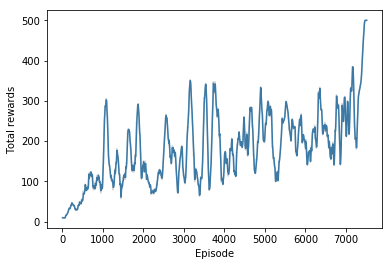

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

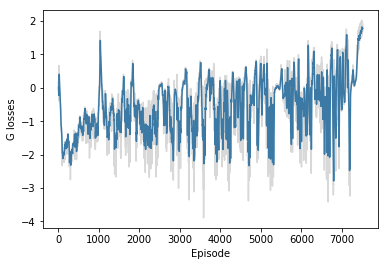

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

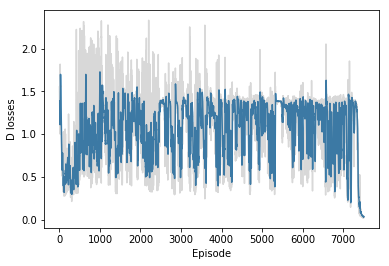

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

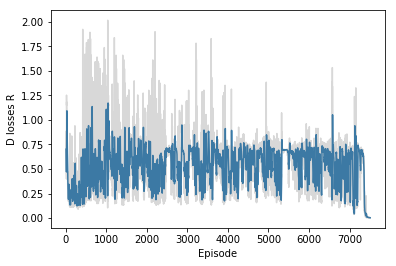

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

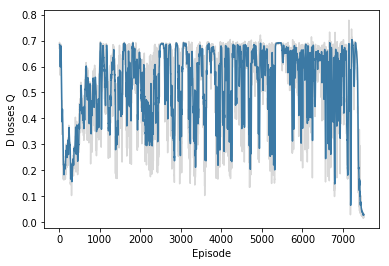

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [37]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.